# interpolating between transport on SSH contours

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d



import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:43767' processes=4 threads=8, memory=32.00 GiB>

Load contour picture with MKE

In [3]:
EKE = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/EKE_10yr.nc').EKE
MKE = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MKE_10yr.nc').MKE
Reynolds = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/Reynolds_10yr_fulldepth.nc').Reynolds
Form_stress = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/Form_stress_10yr_fulldepth.nc').Form_stress

In [4]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [5]:
# This example script just calculates transports for a single year. 
# You'll need to run it multiple times (or set up loop over years)

year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
# Note: change this range, so it matches the size of your contour arrays:

## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)
#-0.1,2,3,4,5#
lat_range = slice(-60,-34.99)
lat_range_big = slice(-60.05,-34.90)
#-0.6,7#
lat_range = slice(-60,-39.98)
lat_range_big = slice(-60.05,-39.90)
#-0.8,-0.9,-1.0#
lat_range = slice(-62.91,-45)
lat_range_big = slice(-62.96,-44.90)
#-1.1,1.2#
lat_range = slice(-64.99,-47)
lat_range_big = slice(-65.02,-46.93)
#-1.3,1.4,-1.5#
lat_range = slice(-70,-47)
lat_range_big = slice(-70.05,-46.93)
# Select contour depth



In [6]:
from collections import OrderedDict


In [7]:
hotspot_dict = OrderedDict([
    ('PAR',  {'lon_slice':slice(-160,-130),'lat_slice':slice(-60,-50)}),
    ('KP',  {'lon_slice':slice(-280,-250),'lat_slice':slice(-60,-40)}),
    ('SWIR',  {'lon_slice':slice(10,50),'lat_slice':slice(-55,-45)}),
    ('DP',  {'lon_slice':slice(-70,-30),'lat_slice':slice(-60,-40)}),
    ('MR',  {'lon_slice':slice(-210,-170),'lat_slice':slice(-60,-45)}),

])

CPU times: user 805 ms, sys: 324 ms, total: 1.13 s
Wall time: 3.7 s


Text(0.5, 1.0, 'SWIR Smoothed Eddy Transport across contours, sigma_1 = 1032.4, averaged over 10 years')

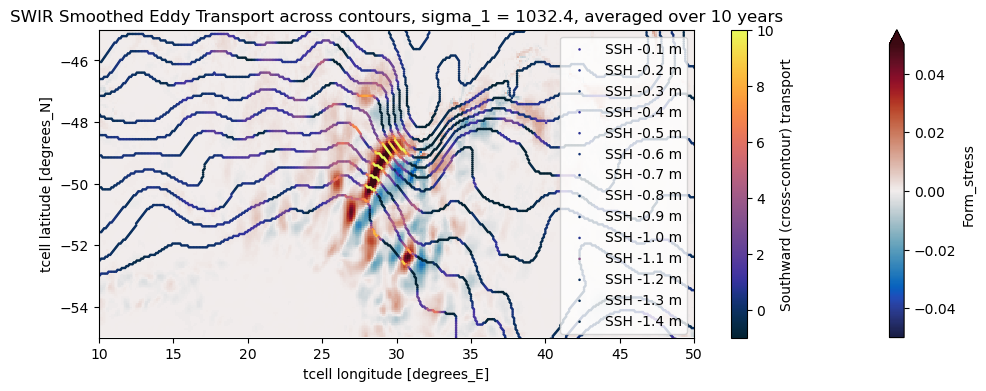

In [8]:
%%time
ekey = 'SWIR'
year = '2170'
fig = plt.figure(figsize = (12,4))
lat_slice = hotspot_dict[ekey]['lat_slice']
lon_slice = hotspot_dict[ekey]['lon_slice']
isopycnal_bins_sigma1 = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,32.3,
                                        32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])
rho = 1032.4
Form_stress.sel(isopycnal_bins = rho, method = 'nearest').sel(yt_ocean = lat_slice,xt_ocean = lon_slice).plot(cmap = cm.cm.balance, vmax = 0.05, vmin = -0.05)

for j in np.arange(14):
    j_contour = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N'])[j]
    color = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14'][j]
    SSH = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0,-1.1,-1.2,-1.3,-1.4][j]
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour
    isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
    top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour.nc').top_rho1_max_contour
    bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour.nc').bottom_rho1_min_contour
    segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length.nc').segment_length
    vh_eddy= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)

    N=10

    eddy_notcumsum = vh_eddy.sel(isopycnal_bins=slice(1030,1032.5)).sum('isopycnal_bins').fillna(0)
    y = uniform_filter1d(eddy_notcumsum, size=N)/segment_length.values
#     dx, dy = find_arrow_dxn(lon_along_contour,lat_along_contour)
#     for i in np.arange(10,len(lon_along_contour),25):

#         plt.arrow(lon_along_contour[i],lat_along_contour[i],y[i]/400*dx[i],y[i]/400*dy[i],head_width = 0.2, head_length = 0.2,length_includes_head=True, color = color)#, head_length = 0.1,length_includes_head=True)

    sc = plt.scatter(lon_along_contour,lat_along_contour, s=0.7, label = 'SSH '+str(SSH)+' m', c = -y , cmap = cm.cm.thermal, vmin = -1, vmax = 10)

plt.legend(loc = 'upper right')
cbar = fig.colorbar(sc)
cbar.set_label('Southward (cross-contour) transport', rotation=90)
plt.ylim(-55,-45)
plt.xlim(10,50)

plt.title('SWIR Smoothed Eddy Transport across contours, sigma_1 = '+str(rho)+', averaged over 10 years')

### Want to fill in the gaps between contours, so relationship with form stress conversion can be better observed

In [9]:
expt = '01deg_jra55v13_ryf9091'

## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)

xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)




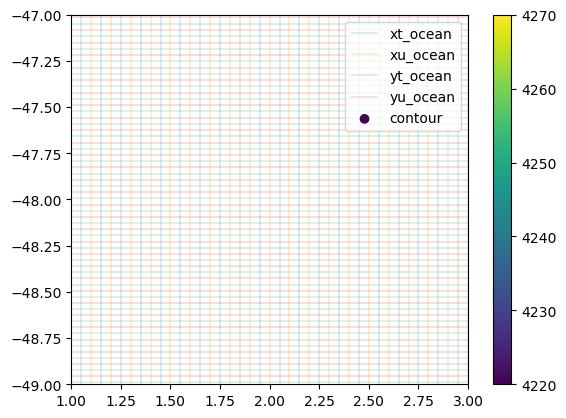

In [10]:
plt.vlines(xt_ocean.values, -50,-45, linewidth = 0.2, label = 'xt_ocean')
plt.vlines(xu_ocean.values, -50,-45, linewidth = 0.2, label = 'xu_ocean', color = 'C1')
plt.hlines(yt_ocean.values, 1,3, linewidth = 0.2, label = 'yt_ocean', color = 'C2')
plt.hlines(yu_ocean.values, 1,3, linewidth = 0.2, label = 'yu_ocean', color = 'C3')




plt.scatter(lon_along_contour, lat_along_contour, marker = 'o', label = 'contour', c = lon_along_contour.contour_index, vmin = 4220,vmax = 4270)
plt.colorbar()
plt.xlim(1,3)
plt.ylim(-49,-47)
plt.legend()

#### create an array of t and u grids together since the contours have values on both.

In [11]:
xt_ocean = xt_ocean.rename({'xt_ocean':'x_ocean'})
xu_ocean = xu_ocean.rename({'xu_ocean':'x_ocean'})
yt_ocean = yt_ocean.rename({'yt_ocean':'y_ocean'})
yu_ocean = yu_ocean.rename({'yu_ocean':'y_ocean'})






In [12]:
x = xr.merge([xt_ocean,xu_ocean])
y = xr.merge([yt_ocean, yu_ocean])
#x = np.arange(-279.95,80.01,0.05)


In [13]:
transport = xr.DataArray(np.zeros((len(x.x_ocean),len(y.y_ocean))), 
                                               coords = [np.round(x.x_ocean.values,2),np.round(y.y_ocean.values,2)], 
                                               dims = ['x_ocean','y_ocean'], 
                                               name = 'transport')
SSH_contours = xr.DataArray(np.zeros((len(x.x_ocean),len(y.y_ocean))), 
                                               coords = [np.round(x.x_ocean.values,2),np.round(y.y_ocean.values,2)], 
                                               dims = ['x_ocean','y_ocean'], 
                                               name = 'SSH_contours')



In [8]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

### Fill in transport data on known coordinates

In [15]:
for j in np.arange(35):
    j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[j]
    SSH = contour_dict[j_contour]['SSH']
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour.values
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour.values
    isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
    #top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour.nc').top_rho1_max_contour
    #bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour.nc').bottom_rho1_min_contour
    segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length.nc').segment_length
    #vh_eddy= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)

    N=10

    eddy_notcumsum = vh_eddy.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').fillna(0)
    y = uniform_filter1d(eddy_notcumsum, size=N)/segment_length.values

    for i in range(len(lat_along_contour)):
        transport.loc[dict(x_ocean=np.round(lon_along_contour[i],2), y_ocean = np.round(lat_along_contour[i],2))] = y[i]
        SSH_contours.loc[dict(x_ocean=np.round(lon_along_contour[i],2), y_ocean = np.round(lat_along_contour[i],2))] = SSH
#     transport.loc[dict(x_ocean=lon_along_contour, y_ocean = lat_along_contour)] = y
#     SSH_contours.loc[dict(x_ocean=lon_along_contour, y_ocean = lat_along_contour)] = SSH


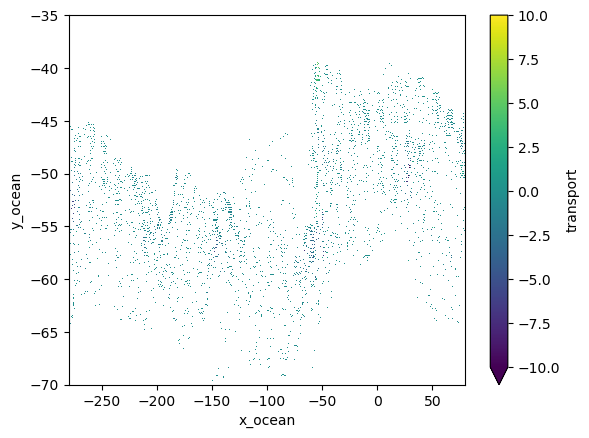

In [16]:
transport.where(transport !=0).plot(vmax = 10, vmin = -10, x = 'x_ocean')

# For each point, find points along adjacent contours that are closest to the points, and weight transport according to the distances

In [17]:
hotspot_dict = OrderedDict([
('PAR',  {'lower_lon':-160,'upper_lon':-110}),
('SWIR',  {'lower_lon':10,'upper_lon':50}),
('DP',  {'lower_lon':-70,'upper_lon':0}),
('MR',  {'lower_lon':-220,'upper_lon':-170}),
('KP1',  {'lower_lon':60,'upper_lon':80}),
('KP2',{'lower_lon':-280,'upper_lon':-260})])


First, select hotspot region. This is for Kerguelen Plateau, which is on the edge, so we roll into different coordin

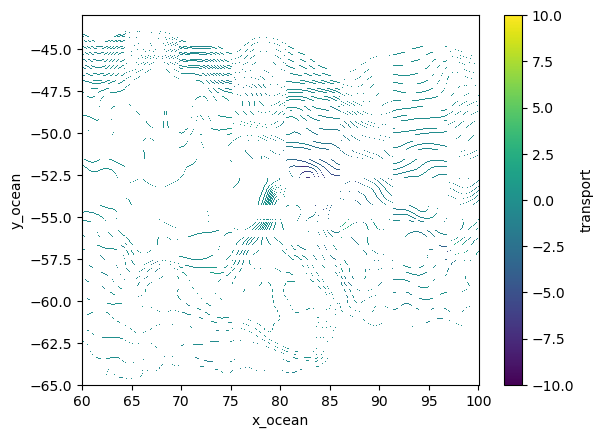

In [33]:
transport_mini = transport.roll(x_ocean = 1600)
transport_mini['x_ocean'] = np.arange(0.05,360.01,0.05)
transport_mini = transport_mini.sel(x_ocean = slice(60,100),y_ocean = slice(-65,-43))
SSH_contour_mini = SSH_contours.roll(x_ocean = 1600)
SSH_contour_mini['x_ocean'] = np.arange(0.05,360.01,0.05)
SSH_contour_mini = SSH_contour_mini.sel(x_ocean = slice(60,100),y_ocean = slice(-65,-43))
transport_mini.where(transport_mini !=0).plot(vmax = 10, vmin = -10, x = 'x_ocean')


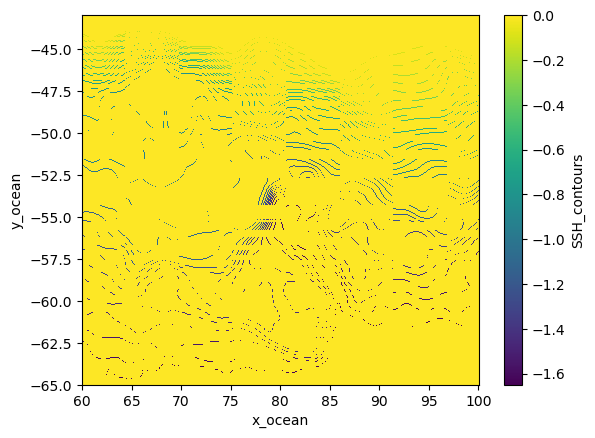

In [34]:
SSH_contour_mini.plot(x = 'x_ocean')

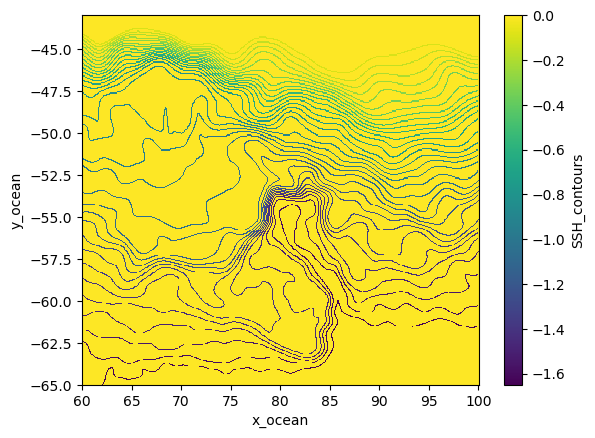

In [35]:
SSH_filter = SSH_contour_mini.copy()
for i in range(len(SSH_filter.x_ocean)-1):
    for j in range(len(SSH_filter.y_ocean)-1):
        if SSH_filter[i,j]==0:
            if SSH_filter[i+1,j]!=0:
                SSH_filter[i,j]=SSH_filter[i+1,j]
            elif SSH_filter[i,j+1]!=0:
                SSH_filter[i,j]=SSH_filter[i,j+1]
            elif SSH_filter[i+1,j+1]!=0:
                SSH_filter[i,j]=SSH_filter[i+1,j+1]
        if j==len(SSH_filter.y_ocean)-1:
            if SSH_filter[i-1,j]!=0:
                SSH_filter[i,j]=SSH_filter[i-1,j]
            elif SSH_filter[i,j-1]!=0:
                SSH_filter[i,j]=SSH_filter[i,j-1]
            elif SSH_filter[i-1,j-1]!=0:
                SSH_filter[i,j]=SSH_filter[i-1,j-1]


            
SSH_filter.plot(x = 'x_ocean')

In [36]:
#contour_mask = contour_mask[1:-2][1:-2]
contour_mask_numbered = SSH_filter.where(SSH_filter == -0.1).fillna(0).transpose('y_ocean','x_ocean')

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above1 = np.copy(contour_mask_numbered)

contour_masked_above1[-1,0] = -100
contour_masked_above[-1,0] = -100
contour_masked_above[-1,-1] = -100

# from top left:
for ii in range(len(contour_mask_numbered.x_ocean)-1):
    for jj in range(len(contour_mask_numbered.y_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
#             if contour_masked_above[jj-1,ii+1] == 0:
#                 contour_masked_above[jj-1,ii+1] = -100
#from top right:
# for ii in range(len(contour_mask_numbered.x_ocean))[::-1][:-1]:
#     for jj in range(len(contour_mask_numbered.y_ocean))[::-1][:-1]:
#         if contour_masked_above[jj,ii] == -100:
#             if contour_masked_above[jj-1,ii] == 0:
#                 contour_masked_above[jj-1,ii] = -100
#             if contour_masked_above[jj,ii-1] == 0:
#                 contour_masked_above[jj,ii-1] = -100
#             if contour_masked_above[jj-1,ii-1] == 0:
#                 contour_masked_above[jj-1,ii-1] = -100
# # from bottom right:
for ii in range(len(contour_mask_numbered.x_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask_numbered.y_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
# #             if contour_masked_above[jj+1,ii-1] == 0:
# #                 contour_masked_above[jj+1,ii-1] = -100
# #from bottom left:
for ii in range(len(contour_mask_numbered.x_ocean)-1):
    for jj in range(len(contour_mask_numbered.y_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
                print('helo')
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
# #             if contour_masked_above[jj+1,ii+1] == 0:
# #                 contour_masked_above[jj+1,ii+1] = -100
top_mask = SSH_filter*0+ np.transpose(contour_masked_above)

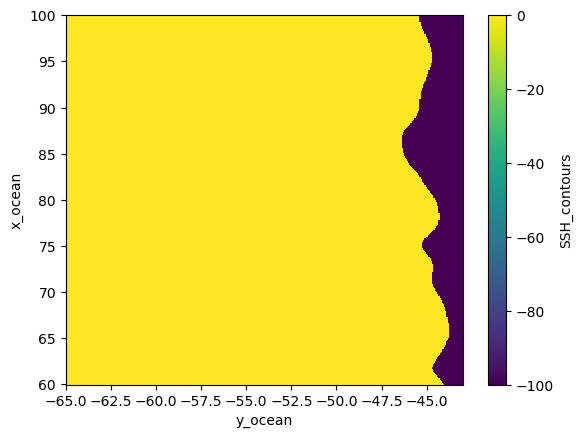

In [37]:
top_mask.plot()

In [38]:
#contour_mask = contour_mask[1:-2][1:-2]
contour_mask_numbered = SSH_filter.where(SSH_filter == -1.65).fillna(0).transpose('y_ocean','x_ocean')

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above1 = np.copy(contour_mask_numbered)

contour_masked_above1[-1,0] = -100
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(contour_mask_numbered.x_ocean)-1):
    for jj in range(len(contour_mask_numbered.y_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
#             if contour_masked_above[jj-1,ii+1] == 0:
#                 contour_masked_above[jj-1,ii+1] = -100
# from top right:
# for ii in range(len(contour_mask_numbered.x_ocean))[::-1][:-1]:
#     for jj in range(len(contour_mask_numbered.y_ocean))[::-1][:-1]:
#         if contour_masked_above[jj,ii] == -100:
#             if contour_masked_above[jj-1,ii] == 0:
#                 contour_masked_above[jj-1,ii] = -100
#             if contour_masked_above[jj,ii-1] == 0:
#                 contour_masked_above[jj,ii-1] = -100
#             if contour_masked_above[jj-1,ii-1] == 0:
#                 contour_masked_above[jj-1,ii-1] = -100
# # from bottom right:
for ii in range(len(contour_mask_numbered.x_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask_numbered.y_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
# #             if contour_masked_above[jj+1,ii-1] == 0:
# #                 contour_masked_above[jj+1,ii-1] = -100
# #from bottom left:
for ii in range(len(contour_mask_numbered.x_ocean)-1):
    for jj in range(len(contour_mask_numbered.y_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
                print('helo')
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
# #             if contour_masked_above[jj+1,ii+1] == 0:
# #                 contour_masked_above[jj+1,ii+1] = -100
bottom_mask =  SSH_filter*0+ np.transpose(contour_masked_above)

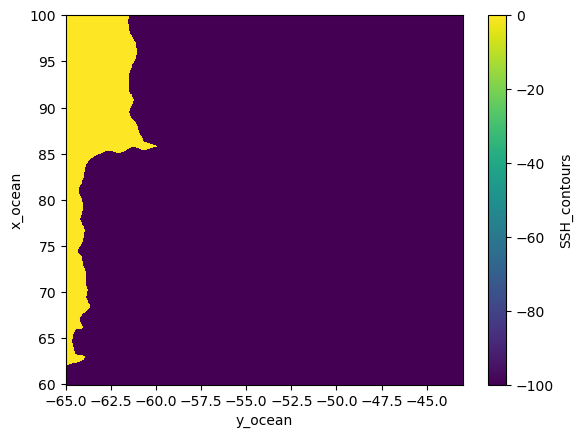

In [39]:
bottom_mask.plot()

In [40]:
%%time
SSH_contour_mini_nan = SSH_contour_mini.where(SSH_contour_mini !=0)
xs = SSH_contour_mini_nan*0+SSH_contour_mini_nan.x_ocean
ys = SSH_contour_mini_nan*0+SSH_contour_mini_nan.y_ocean

xs2 = SSH_contour_mini*0+SSH_contour_mini.x_ocean
ys2 = SSH_contour_mini*0+SSH_contour_mini.y_ocean


transport_new = transport_mini.copy()
transport_new = transport_new.where(top_mask !=-100).where(bottom_mask !=0)

CPU times: user 27.8 ms, sys: 142 µs, total: 28 ms
Wall time: 24.7 ms


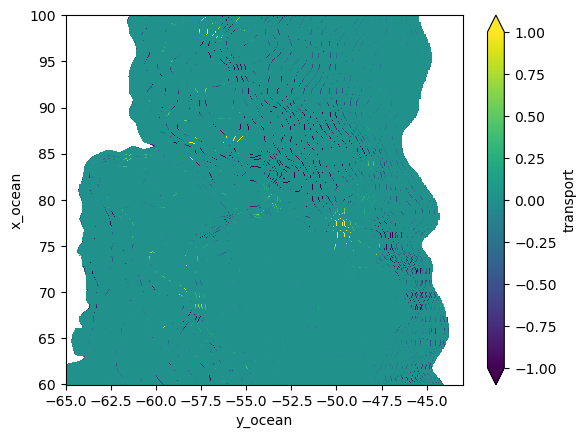

In [41]:
transport_new.plot(vmin = -1, vmax = 1)

In [42]:
%%time


for i in range(len(transport_new.x_ocean)-1):
    print(i)
    for j in range(len(transport_new.y_ocean)-1):
        if transport_new[i,j]==0:
            dist_ij = (xs-transport_new.x_ocean[i])**2+(ys-transport_new.y_ocean[j])**2
            dist_ij_1_x = dist_ij.min('y_ocean').argmin('x_ocean')
            dist_ij_1_y = dist_ij.min('x_ocean').argmin('y_ocean')
            dist_ij_1 = dist_ij.min('x_ocean').min('y_ocean')
            dist_ij_SSH = SSH_contour_mini_nan.isel(x_ocean = dist_ij_1_x, y_ocean = dist_ij_1_y)
            dist_ij_2_x = dist_ij.where(SSH_contour_mini_nan != dist_ij_SSH).min('y_ocean').argmin('x_ocean')
            dist_ij_2_y = dist_ij.where(SSH_contour_mini_nan != dist_ij_SSH).min('x_ocean').argmin('y_ocean')
            dist_ij_2 = dist_ij.where(SSH_contour_mini_nan != dist_ij_SSH).min('y_ocean').min('x_ocean')
            #dist_ij_SSH = SSH_contour_mini_nan.isel(x_ocean = dist_ij_2_x, y_ocean = dist_ij_2_y)
            ratio_1 = 1-dist_ij_1.values/(dist_ij_1.values+dist_ij_2.values)
            transport_new[i,j] = ratio_1*transport_mini.isel(x_ocean = dist_ij_1_x, y_ocean = dist_ij_1_y)+(1-ratio_1)*transport_mini.isel(x_ocean = dist_ij_2_x, y_ocean = dist_ij_2_y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

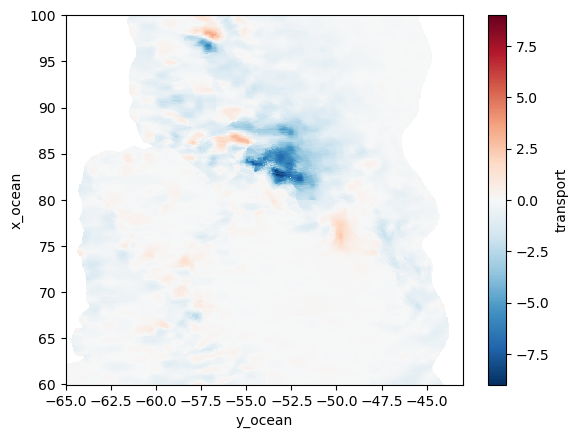

In [43]:
transport_new.plot()

In [44]:
vh_eddy_interp = transport_new.transpose('y_ocean','x_ocean')
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'vh_eddy_interp': vh_eddy_interp})
ds.to_netcdf(save_dir+'KP_vh_eddy_interp_upwellingarm_constant.nc')


In [19]:
transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp

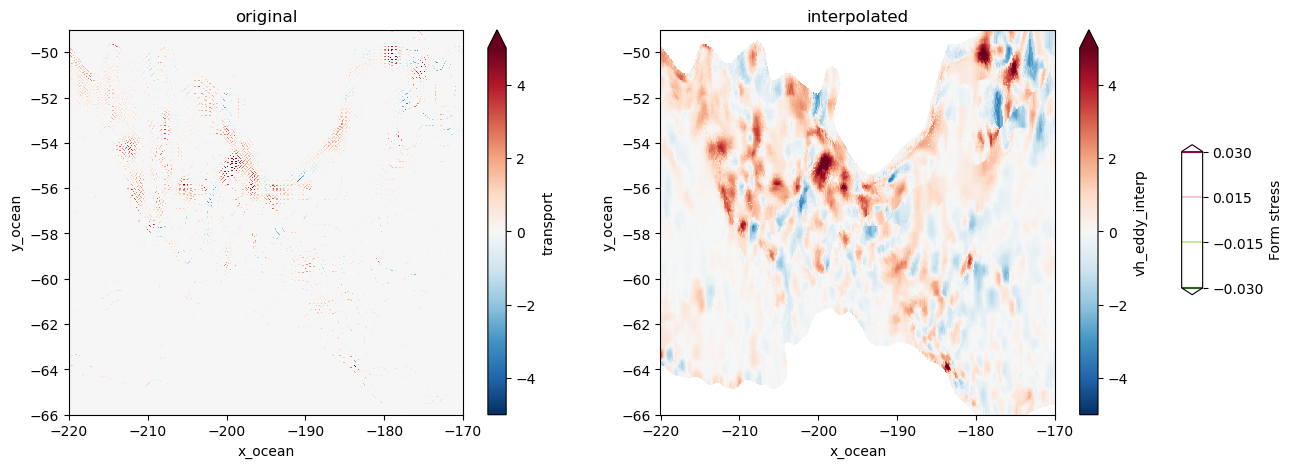

In [22]:
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (14,5))

(-transport_mini).plot(ax= axes[0],x = 'x_ocean', vmax = 5, vmin = -5, cmap = 'RdBu_r')
#Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-55,-45),xt_ocean = slice(20,40)).plot.contour(ax = axes[0], cmap = cm.cm.balance, levels = [-0.03,-0.015,0,0.015,0.03], linewidth = 0.5)
axes[0].set_title('original');
(-transport_new).plot(ax= axes[1],x = 'x_ocean', vmax = 5, vmin = -5, cmap = 'RdBu_r')
#isopycnal_bin_array = Form_stress*0+Form_stress.isopycnal_bins
#a = Form_stress#.where(isopycnal_bin_array > top_rho1_max_contour).where(isopycnal_bin_array <bottom_rho1_min_contour).fillna(0)
#p1 = a.sel(isopycnal_bins = slice(1032,1032.5), yt_ocean = slice(-66,-49),xt_ocean = slice(-220,-170)).sum('isopycnal_bins').plot.contour(ax = axes[1],cmap = 'PiYG_r', levels = [-0.03,-0.015,0.015,0.03], linewidth = 0.5)
#p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-66,-49),xt_ocean = slice(-220,-170)).plot.contour(ax = axes[1], levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
ax_cb = plt.axes([0.92, 0.35, 0.015, 0.3])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Form stress');
axes[1].set_title('interpolated');



In [25]:
a = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-66,-49),xt_ocean = slice(-220,-170))
transport_new_interp = transport_new.interp({'x_ocean':a.xt_ocean,'y_ocean':a.yt_ocean})


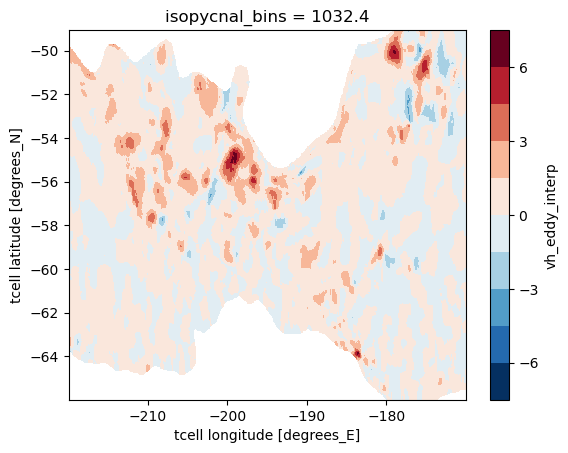

In [30]:
(-transport_new_interp).plot.contourf(levels = 11)

In [13]:
from matplotlib import gridspec


In [46]:
bottom_rho1_min = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_bottom_density_min.nc').bottom_rho1
top_rho1_max = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_top_density_max.nc').top_rho1


In [70]:
isopycnal_bin_array = EKE*0+EKE.isopycnal_bins
EKE_upwelling = EKE.where(isopycnal_bin_array > top_rho1_max).where(isopycnal_bin_array<bottom_rho1_min)
EKE_upwelling = EKE_upwelling.sel(isopycnal_bins = slice(1030,1032.5)).sum('isopycnal_bins')

FS_upwelling = Form_stress.where(isopycnal_bin_array > top_rho1_max).where(isopycnal_bin_array<bottom_rho1_min)
FS_upwelling = FS_upwelling.sel(isopycnal_bins = slice(1030,1032.5)).sum('isopycnal_bins')

RS_upwelling = Reynolds.where(isopycnal_bin_array > top_rho1_max).where(isopycnal_bin_array<bottom_rho1_min)
RS_upwelling = RS_upwelling.sel(isopycnal_bins = slice(1030,1032.5)).sum('isopycnal_bins')


Text(105, -50, 'Grey lines at EKE=4x$ 10^3$ (MR and PAR) and 4x$ 10^4$ (others)')

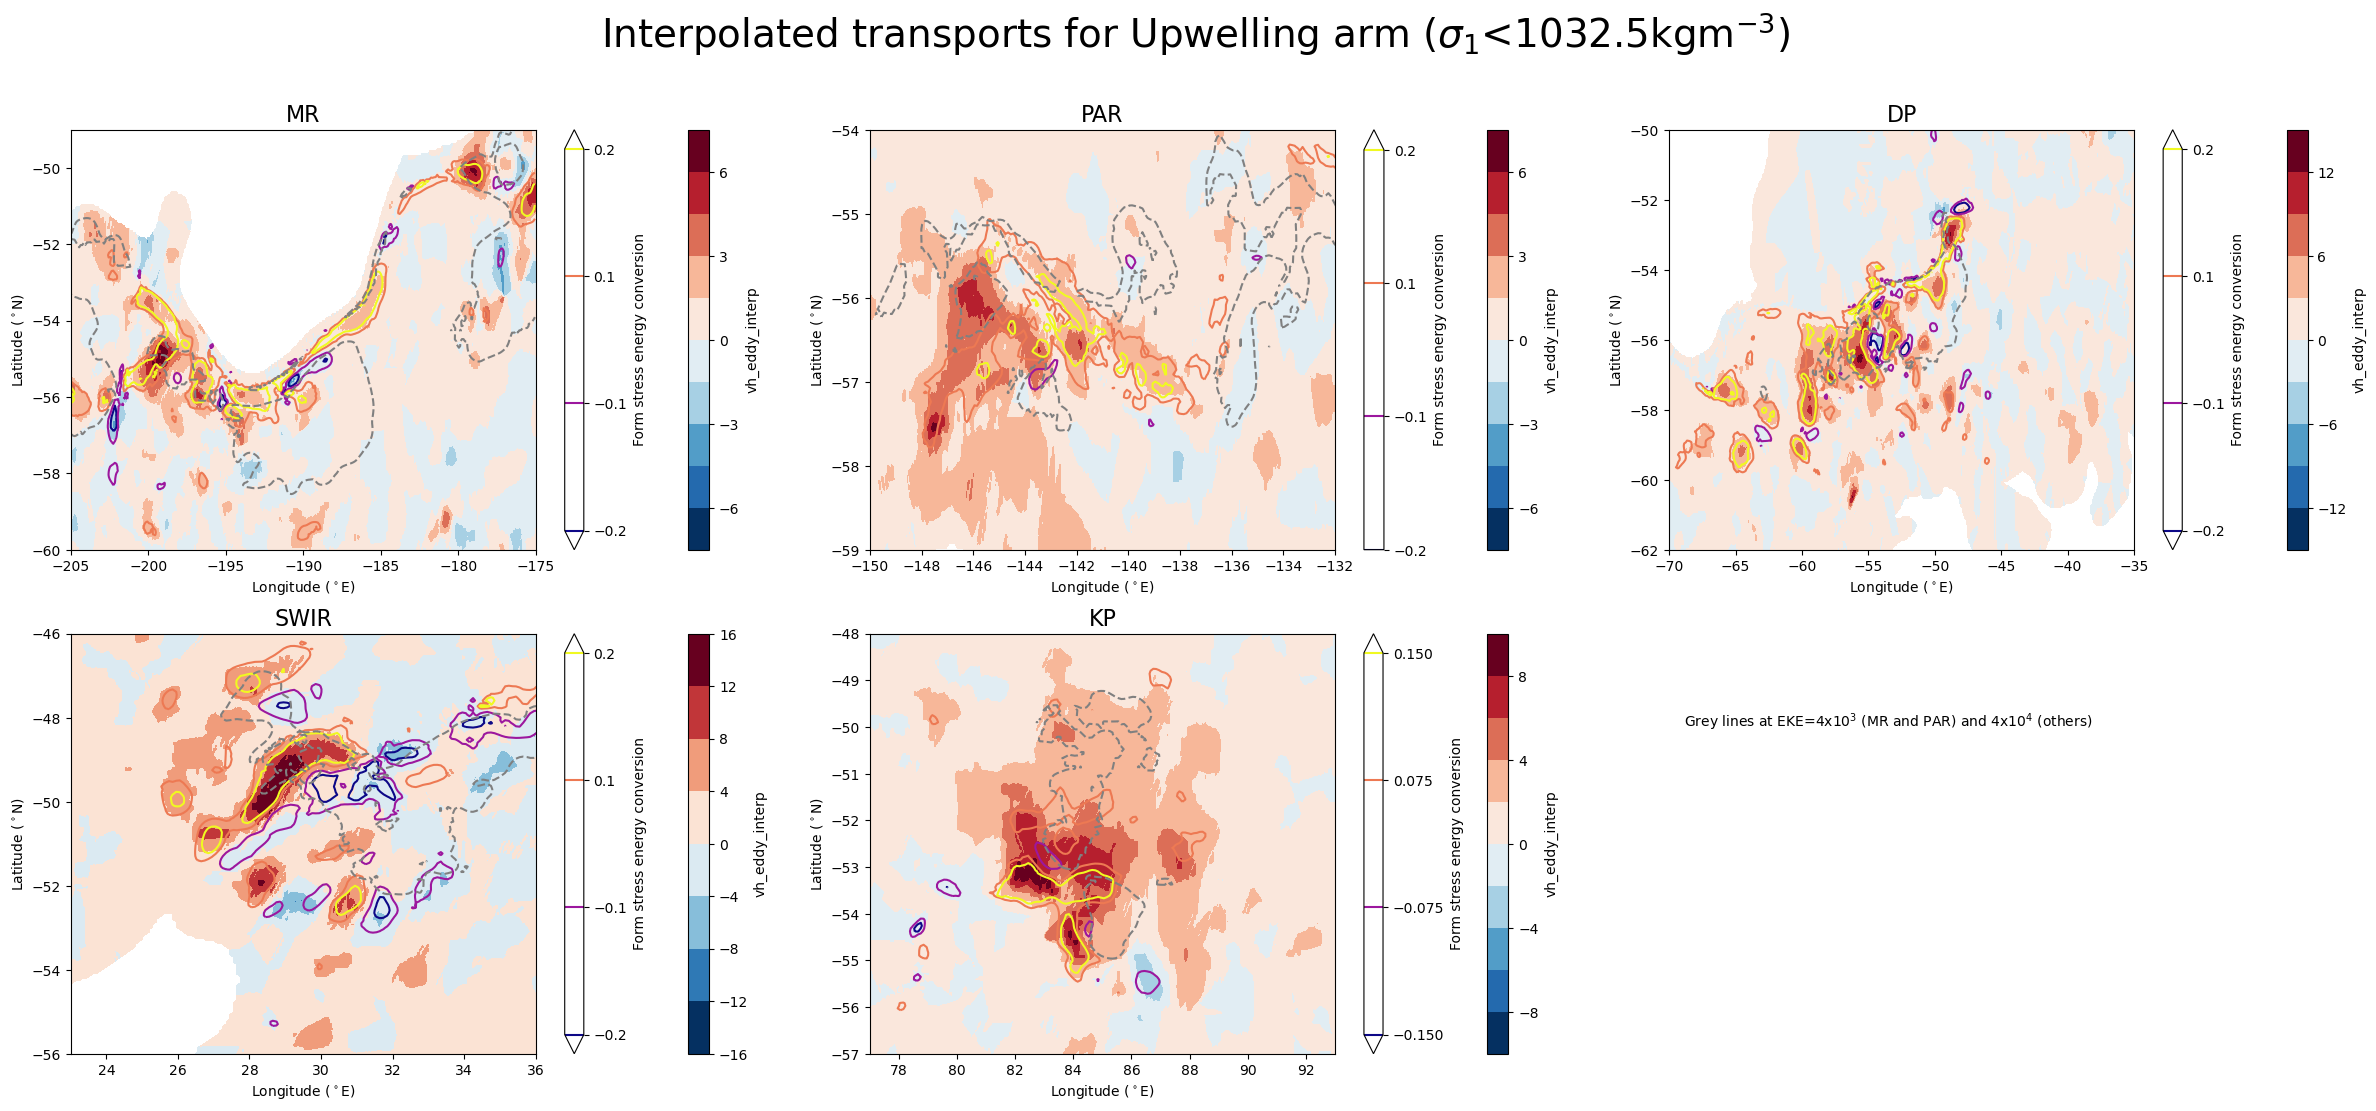

In [30]:
fig = plt.figure(num=1,figsize=(30,12))
gs = gridspec.GridSpec(2,3) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1])
gs.update(hspace = 0.2, wspace=0.1)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp
(-transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = 11, cmap = 'RdBu_r')
p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'plasma', levels = [-0.2,-0.1,0.1,0.2], linewidth = 0.5)
p2 = EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0, levels = [3e4], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax0, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax0.set_title('MR', fontsize = 16);
                                                                                                       
transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                  
(-transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = 11, cmap = 'RdBu_r')
p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'plasma', levels = [-0.2,-0.1,0.1,0.2], linewidth = 0.5)
p2 = EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1, levels = [2e4], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax1, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax1.set_title('PAR', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = 11, cmap = 'RdBu_r')
p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma', levels = [-0.2,-0.1,0.1,0.2], linewidth = 0.5)
p2 = EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2, levels = [4e4], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax2, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax2.set_title('DP', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = 11, cmap = 'RdBu_r')
p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'plasma', levels = [-0.2,-0.1,0.1,0.2], linewidth = 0.5)
p2 = EKE_upwelling.sel(yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3, levels = [4e4], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax3, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax3.set_title('SWIR', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = 11,  cmap = 'RdBu_r')
FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_upwelling_KP = EKE_upwelling.roll(xt_ocean =800)
EKE_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma', levels = [-0.15,-0.075,0.075,0.15], linewidth = 0.5)
p2 = EKE_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4, levels = [4e4], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax4, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax4.set_title('KP', fontsize = 16);

fig.suptitle('Interpolated transports for Upwelling arm ($\sigma_1$<1032.5kgm$^{-3}$)', fontsize = 28)

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('Longitude ($^\circ$E)')
ax1.set_ylabel('Latitude ($^\circ$N)')
ax1.set_xlabel('Longitude ($^\circ$E)')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-205,-175)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-35)
ax2.set_ylim(-62,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)
ax4.text(105,-50,'Grey lines at EKE=4x$ 10^3$ (MR and PAR) and 4x$ 10^4$ (others)')

(-57.0, -48.0)

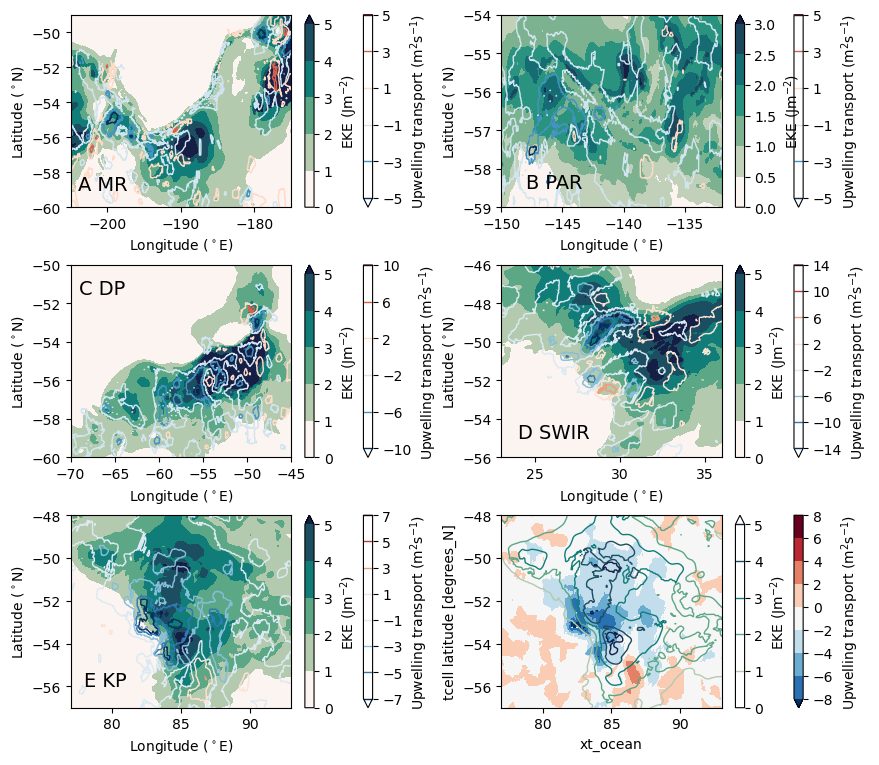

In [133]:
newcmap = cm.tools.crop_by_percent(cm.cm.tempo, 1, which='both', N= None)
fig = plt.figure(num=1,figsize=(10,9))
gs = gridspec.GridSpec(3,2) 
ax0, ax1, ax2, ax3, ax4, ax6 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0]),plt.subplot(gs[2,1])
gs.update(hspace = 0.3, wspace=0.25)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp
p0 = (transport_new).plot.contour(ax= ax0,x = 'x_ocean', levels = [-5,-3,-1,1,3,5], cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'plasma', levels = [-0.2,-0.1,0.1,0.2], linewidth = 0.5)
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0, add_colorbar = False, levels = [0,1,2,3,4,5], cmap = newcmap, linewidth =1)#, linestyles = '--')
cb = plt.colorbar(p2,ax=ax0, orientation='vertical')
cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
ax0.text(-204,-59,'A MR', fontsize = 14);
                                                                                                       
transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contour(ax= ax1,x = 'x_ocean', levels = [-5,-3,-1,1,3,5], cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'plasma', levels = [-0.2,-0.1,0.1,0.2], linewidth = 0.5)
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1, add_colorbar = False,levels = [0,0.5,1,1.5,2,2.5,3], cmap = newcmap, linewidth = 0.5)#, linestyles = '--')
cb = plt.colorbar(p2,ax=ax1, orientation='vertical')
cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
ax1.text(-148,-58.5,'B PAR', fontsize = 14);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contour(ax= ax2,x = 'x_ocean', levels = [-10,-6,-2,2,6,10], cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma', levels = [-0.2,-0.1,0.1,0.2], linewidth = 0.5)
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contourf(ax = ax2, add_colorbar = False,levels = [0,1,2,3,4,5], cmap = newcmap, linewidth = 0.5)#, linestyles = '--')
cb = plt.colorbar(p2,ax=ax2, orientation='vertical')
cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
ax2.text(-69,-51.5,'C DP', fontsize = 14);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contour(ax= ax3,x = 'x_ocean', levels = [-14,-10,-6,-2,2,6,10,14], cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'plasma', levels = [-0.2,-0.1,0.1,0.2], linewidth = 0.5)
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contourf(ax = ax3, add_colorbar = False,levels = [0,1,2,3,4,5], cmap = newcmap, linewidth = 0.5)#, linestyles = '--')
cb = plt.colorbar(p2,ax=ax3, orientation='vertical')
cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
ax3.text(24,-55,'D SWIR', fontsize = 14);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contour(ax= ax4,x = 'x_ocean', levels = [-7,-5,-3,-1,1,3,5,7], cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_upwelling_KP = EKE_upwelling.roll(xt_ocean =800)
EKE_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
#p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma', levels = [-0.15,-0.075,0.075,0.15], linewidth = 0.5)
p2 = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contourf(ax = ax4, add_colorbar = False,levels = [0,1,2,3,4,5], cmap = newcmap, linewidths = 0.5)#, linestyles = '--')
cb = plt.colorbar(p2,ax=ax4, orientation='vertical')
cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
ax4.text(78,-56,'E KP', fontsize = 14);

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('Longitude ($^\circ$E)')
ax1.set_ylabel('Latitude ($^\circ$N)')
ax1.set_xlabel('Longitude ($^\circ$E)')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-205,-175)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)


## Alternative Plot##
transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax6,x = 'x_ocean', levels = np.arange(-8,9,2), cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax6, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_upwelling_KP = EKE_upwelling.roll(xt_ocean =800)
EKE_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
#p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma', levels = [-0.15,-0.075,0.075,0.15], linewidth = 0.5)
p2 = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax6, add_colorbar = False,levels = [0,1,2,3,4,5], cmap = newcmap, linewidths = 1)#, linestyles = '--')
cb = plt.colorbar(p2,ax=ax6, orientation='vertical')
cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
ax6.set_xlim(77,93)
ax6.set_ylim(-57,-48)


In [18]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 12})

In [10]:
import matplotlib as mpl

In [11]:
n=35
x = 0.5
lower = plt.cm.RdBu_r(np.linspace(0, x, n))
white = plt.cm.RdBu_r(np.ones(80-2*n)*x)
upper = plt.cm.RdBu_r(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
tmap = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)


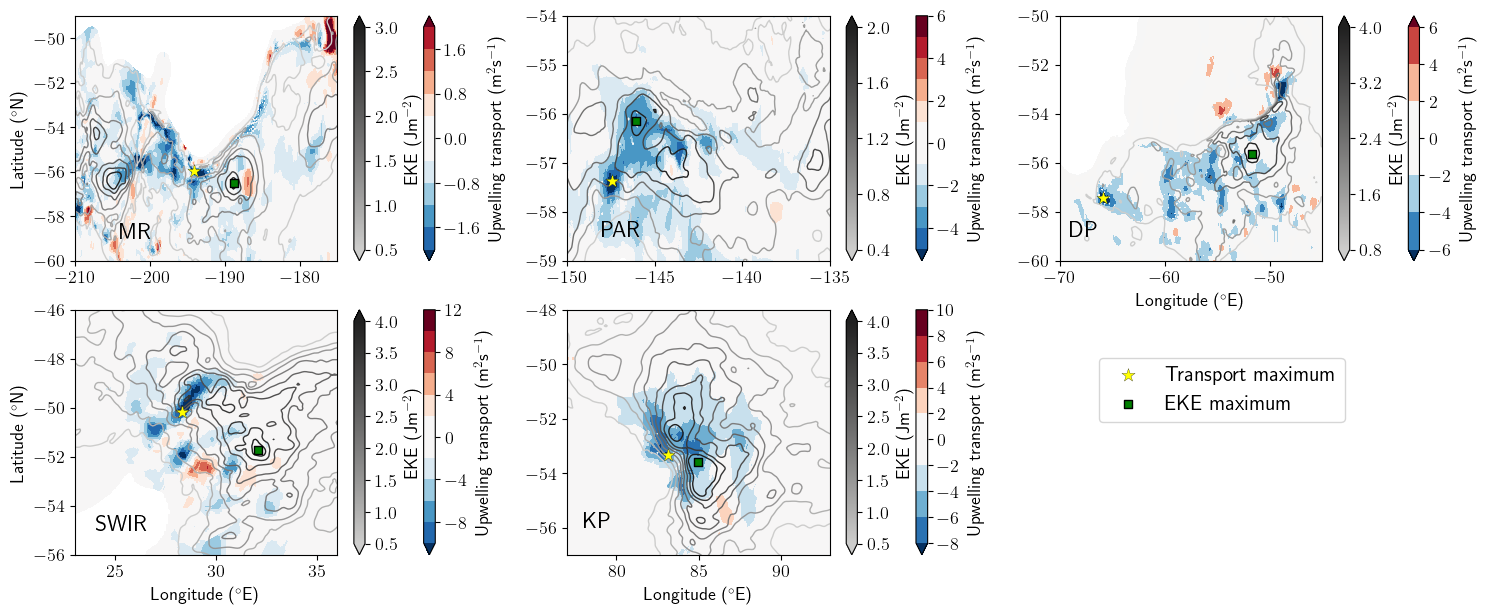

In [14]:
newcmap = cm.tools.crop_by_percent(cm.cm.gray_r, 30, which='both', N= None)
fig = plt.figure(num=1,figsize=(18,7))
gs = gridspec.GridSpec(2,3) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1])
gs.update(hspace = 0.2, wspace=0.2)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp
p0 = (transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = np.arange(-2.0,2.1,0.4), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.2962295,1032.51)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-210,-175)).plot.contour(ax = ax0, add_colorbar = False, levels = [0.5,1,1.5,2,2.5,3], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax0, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.5,1,1.5,2,2.5,3])

ax0.text(-204,-59,'MR', fontsize = 16);
x = transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).min('y_ocean').argmin('x_ocean')
y = transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).min('x_ocean').argmin('y_ocean')
ax0.scatter(transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).x_ocean[x],
            transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).y_ocean[y], 
            color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth =0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).max('xt_ocean').argmax('yt_ocean')
ax0.scatter(EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = np.arange(-5,7,1), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1, add_colorbar = False,levels = [0.4,0.8,1.2,1.6,2], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax1, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.4, vmax=2)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax1, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.4,0.8,1.2,1.6,2])

ax1.text(-148,-58.5,'PAR', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax1.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).max('xt_ocean').argmax('yt_ocean')
ax1.scatter(EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################


transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-6,7,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.13010113,1032.48)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2, add_colorbar = False,levels = [0.8,1.6,2.4,3.2,4], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax2, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.8, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax2, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.8,1.6,2.4,3.2,4])

ax2.text(-69,-59,'DP', fontsize = 16);
x = transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).min('y_ocean').argmin('x_ocean')
y = transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).min('x_ocean').argmin('y_ocean')
ax2.scatter(transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).x_ocean[x],
            transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).y_ocean[y], 
            color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).max('xt_ocean').argmax('yt_ocean')
ax2.scatter(EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-10,13,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'viridis_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.13490907,1032.48)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3, add_colorbar = False,levels = [0.5,1,1.5,2,2.5,3,3.5,4], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax3, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax3, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.5,1,1.5,2,2.5,3,3.5,4])

ax3.text(24,-55,'SWIR', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax3.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).max('xt_ocean').argmax('yt_ocean')
ax3.scatter(EKE_upwelling.sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,11,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', extend = 'both')
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_upwelling_KP = EKE.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').roll(xt_ocean =800)
EKE_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
#p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = cm.cm.delta_r, levels = [-0.15,-0.075,0.075,0.15], add_colorbar = False, linewidths = 1)
p2 = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4, add_colorbar = False,levels = [0.5,1,1.5,2,2.5,3,3.5,4], cmap = newcmap, linewidths = 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax4, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax4, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both', ticks = [0.5,1,1.5,2,2.5,3,3.5,4])

ax4.text(78,-56,'KP', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax4.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2, label = 'Transport maximum')
x = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).max('xt_ocean').argmax('yt_ocean')
ax4.scatter(EKE_upwelling_KP.sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).xt_ocean[x],
            EKE_upwelling_KP.sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2, label = 'EKE maximum')
ax4.legend(bbox_to_anchor=(3,0.5),loc = 'lower right', fontsize = 15)
#############################################################################################

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-210,-175)
ax1.set_xlim(-150,-135)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)

fig.savefig('EKEinterp_landscape.png', dpi = 400)

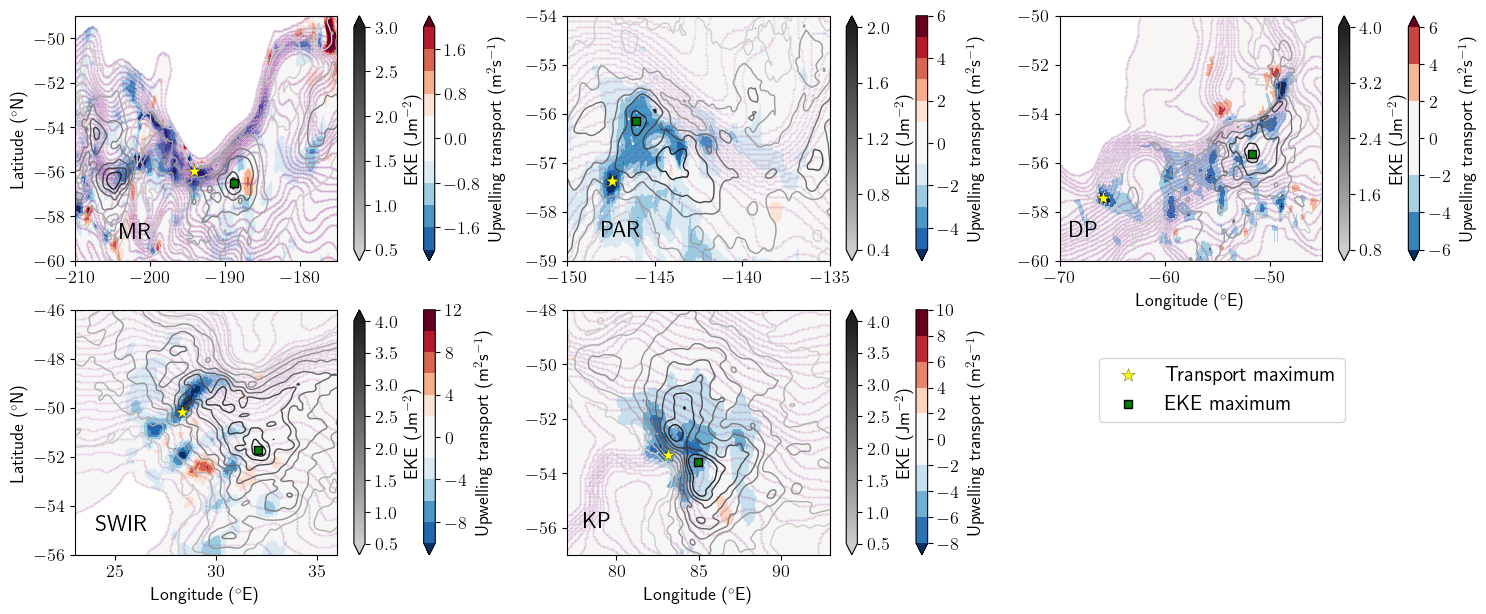

In [19]:
newcmap = cm.tools.crop_by_percent(cm.cm.gray_r, 30, which='both', N= None)
fig = plt.figure(num=1,figsize=(18,7))
gs = gridspec.GridSpec(2,3) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1])
gs.update(hspace = 0.2, wspace=0.2)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp
p0 = (transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = np.arange(-2.0,2.1,0.4), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.2962295,1032.51)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-210,-175)).plot.contour(ax = ax0, add_colorbar = False, levels = [0.5,1,1.5,2,2.5,3], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax0, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.5,1,1.5,2,2.5,3])

ax0.text(-204,-59,'MR', fontsize = 16);
x = transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).min('y_ocean').argmin('x_ocean')
y = transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).min('x_ocean').argmin('y_ocean')
ax0.scatter(transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).x_ocean[x],
            transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).y_ocean[y], 
            color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth =0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).max('xt_ocean').argmax('yt_ocean')
ax0.scatter(EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = np.arange(-5,7,1), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1, add_colorbar = False,levels = [0.4,0.8,1.2,1.6,2], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax1, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.4, vmax=2)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax1, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.4,0.8,1.2,1.6,2])

ax1.text(-148,-58.5,'PAR', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax1.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).max('xt_ocean').argmax('yt_ocean')
ax1.scatter(EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################


transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-6,7,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.13010113,1032.48)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2, add_colorbar = False,levels = [0.8,1.6,2.4,3.2,4], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax2, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.8, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax2, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.8,1.6,2.4,3.2,4])

ax2.text(-69,-59,'DP', fontsize = 16);
x = transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).min('y_ocean').argmin('x_ocean')
y = transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).min('x_ocean').argmin('y_ocean')
ax2.scatter(transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).x_ocean[x],
            transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).y_ocean[y], 
            color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).max('xt_ocean').argmax('yt_ocean')
ax2.scatter(EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-10,13,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'viridis_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.13490907,1032.48)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3, add_colorbar = False,levels = [0.5,1,1.5,2,2.5,3,3.5,4], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax3, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax3, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.5,1,1.5,2,2.5,3,3.5,4])

ax3.text(24,-55,'SWIR', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax3.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).max('xt_ocean').argmax('yt_ocean')
ax3.scatter(EKE_upwelling.sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,11,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', extend = 'both')
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_upwelling_KP = EKE.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').roll(xt_ocean =800)
EKE_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
#p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = cm.cm.delta_r, levels = [-0.15,-0.075,0.075,0.15], add_colorbar = False, linewidths = 1)
p2 = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4, add_colorbar = False,levels = [0.5,1,1.5,2,2.5,3,3.5,4], cmap = newcmap, linewidths = 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax4, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax4, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both', ticks = [0.5,1,1.5,2,2.5,3,3.5,4])

ax4.text(78,-56,'KP', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax4.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2, label = 'Transport maximum')
x = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).max('xt_ocean').argmax('yt_ocean')
ax4.scatter(EKE_upwelling_KP.sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).xt_ocean[x],
            EKE_upwelling_KP.sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2, label = 'EKE maximum')
ax4.legend(bbox_to_anchor=(3,0.5),loc = 'lower right', fontsize = 15)
#############################################################################################

for j in np.arange(35):
    j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                          'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[j]
    SSH = contour_dict[j_contour]['SSH']
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    sc = ax0.scatter(lon_along_contour,lat_along_contour, s=0.1,alpha = 0.2, color = 'purple')
    sc = ax1.scatter(lon_along_contour,lat_along_contour, s=0.1,alpha = 0.2, color = 'purple')
    sc = ax2.scatter(lon_along_contour,lat_along_contour, s=0.1,alpha = 0.2, color = 'purple')
    sc = ax3.scatter(lon_along_contour,lat_along_contour, s=0.1,alpha = 0.2, color = 'purple')
    sc = ax4.scatter(lon_along_contour,lat_along_contour, s=0.1,alpha = 0.2, color = 'purple')
    sc = ax4.scatter(lon_along_contour+360,lat_along_contour, s=0.1,alpha = 0.2, color = 'purple')


ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-210,-175)
ax1.set_xlim(-150,-135)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)

fig.savefig('EKEinterp_landscape.png', dpi = 400)

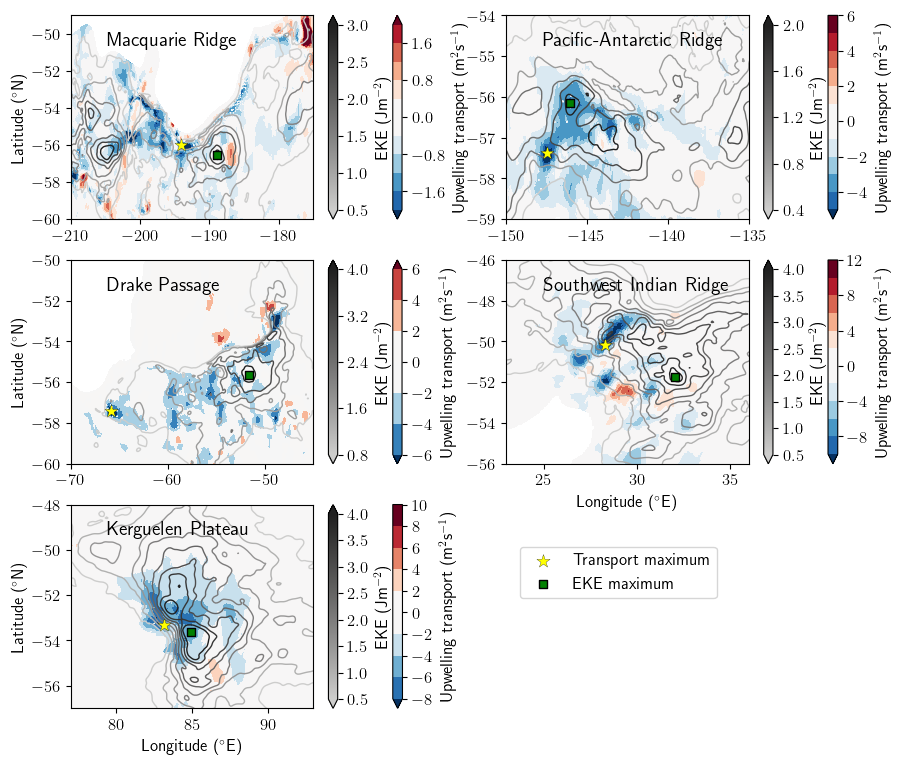

In [20]:
newcmap = cm.tools.crop_by_percent(cm.cm.gray_r, 30, which='both', N= None)
fig = plt.figure(num=1,figsize=(10.5,9))
gs = gridspec.GridSpec(3,2) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0])
gs.update(hspace = 0.2, wspace=0.15)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp
p0 = (transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = np.arange(-2.0,2.1,0.4), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.2962295,1032.51)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-210,-175)).plot.contour(ax = ax0, add_colorbar = False, levels = [0.5,1,1.5,2,2.5,3], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax0, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.5,1,1.5,2,2.5,3])

ax0.text(0.15,0.85,'Macquarie Ridge', fontsize = 14, transform=ax0.transAxes);
x = transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).min('y_ocean').argmin('x_ocean')
y = transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).min('x_ocean').argmin('y_ocean')
ax0.scatter(transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).x_ocean[x],
            transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).y_ocean[y], 
            color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth =0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).max('xt_ocean').argmax('yt_ocean')
ax0.scatter(EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = np.arange(-5,7,1), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1, add_colorbar = False,levels = [0.4,0.8,1.2,1.6,2], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax1, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.4, vmax=2)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax1, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.4,0.8,1.2,1.6,2])

ax1.text(0.15,0.85,'Pacific-Antarctic Ridge', fontsize = 14, transform=ax1.transAxes);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax1.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).max('xt_ocean').argmax('yt_ocean')
ax1.scatter(EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################


transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-6,7,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.13010113,1032.48)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2, add_colorbar = False,levels = [0.8,1.6,2.4,3.2,4], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax2, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.8, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax2, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.8,1.6,2.4,3.2,4])

ax2.text(0.15,0.85,'Drake Passage', fontsize = 14, transform=ax2.transAxes);
x = transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).min('y_ocean').argmin('x_ocean')
y = transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).min('x_ocean').argmin('y_ocean')
ax2.scatter(transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).x_ocean[x],
            transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).y_ocean[y], 
            color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).max('xt_ocean').argmax('yt_ocean')
ax2.scatter(EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-50)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-10,13,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'viridis_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.13490907,1032.48)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3, add_colorbar = False,levels = [0.5,1,1.5,2,2.5,3,3.5,4], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax3, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax3, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.5,1,1.5,2,2.5,3,3.5,4])

ax3.text(0.15,0.85,'Southwest Indian Ridge', fontsize = 14, transform=ax3.transAxes);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax3.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).max('xt_ocean').argmax('yt_ocean')
ax3.scatter(EKE_upwelling.sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,11,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', extend = 'both')
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_upwelling_KP = EKE.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').roll(xt_ocean =800)
EKE_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
#p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = cm.cm.delta_r, levels = [-0.15,-0.075,0.075,0.15], add_colorbar = False, linewidths = 1)
p2 = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4, add_colorbar = False,levels = [0.5,1,1.5,2,2.5,3,3.5,4], cmap = newcmap, linewidths = 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax4, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax4, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both', ticks = [0.5,1,1.5,2,2.5,3,3.5,4])

ax4.text(0.15,0.85,'Kerguelen Plateau', fontsize = 14, transform=ax4.transAxes);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax4.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=100, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2, label = 'Transport maximum')
x = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).max('xt_ocean').argmax('yt_ocean')
ax4.scatter(EKE_upwelling_KP.sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).xt_ocean[x],
            EKE_upwelling_KP.sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2, label = 'EKE maximum')
ax4.legend(bbox_to_anchor=(2.7,0.5),loc = 'lower right')
#############################################################################################

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-210,-175)
ax1.set_xlim(-150,-135)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)

fig.savefig('EKEinterp.png', dpi = 400)

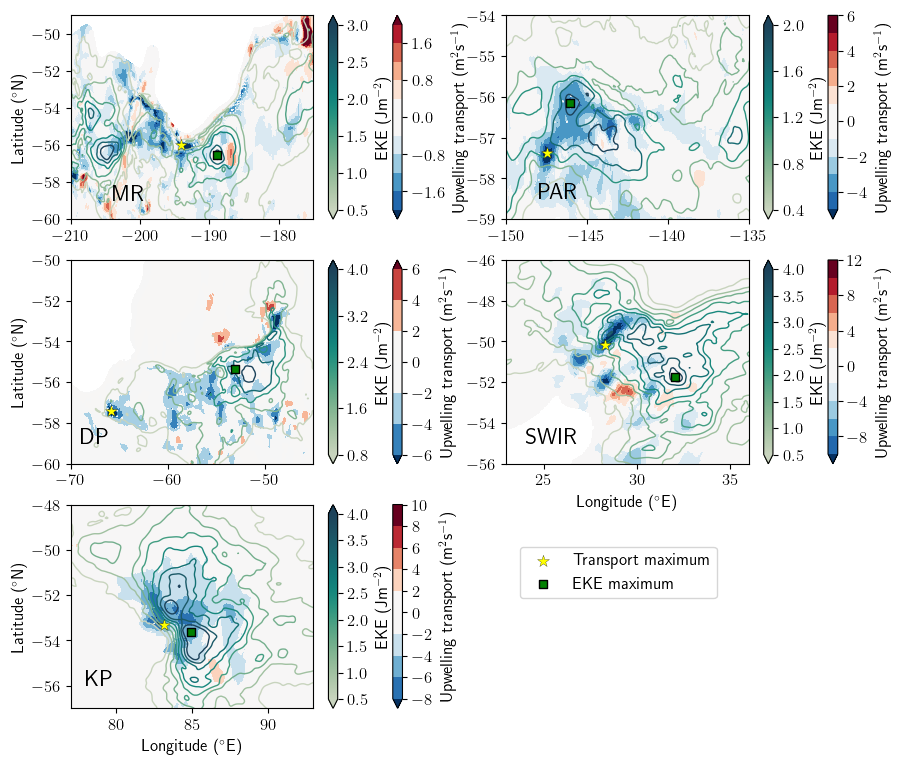

In [97]:
newcmap = cm.tools.crop_by_percent(cm.cm.tempo, 30, which='both', N= None)
fig = plt.figure(num=1,figsize=(10.5,9))
gs = gridspec.GridSpec(3,2) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0])
gs.update(hspace = 0.2, wspace=0.15)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp
p0 = (transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = np.arange(-2.0,2.1,0.4), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.2962295,1032.51)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-210,-175)).plot.contour(ax = ax0, add_colorbar = False, levels = [0.5,1,1.5,2,2.5,3], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax0, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.5,1,1.5,2,2.5,3])

ax0.text(-204,-59,'MR', fontsize = 16);
x = transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).min('y_ocean').argmin('x_ocean')
y = transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).min('x_ocean').argmin('y_ocean')
ax0.scatter(transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).x_ocean[x],
            transport_new.sel(y_ocean = slice(-63,-49),x_ocean = slice(-195,-175)).y_ocean[y], 
            color = 'yellow',s=80, marker = '*', edgecolors = 'k', zorder = 2, linewidth =0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).max('xt_ocean').argmax('yt_ocean')
ax0.scatter(EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-195,-175)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = np.arange(-5,7,1), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1, add_colorbar = False,levels = [0.4,0.8,1.2,1.6,2], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax1, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.4, vmax=2)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax1, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.4,0.8,1.2,1.6,2])

ax1.text(-148,-58.5,'PAR', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax1.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=80, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).max('xt_ocean').argmax('yt_ocean')
ax1.scatter(EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################


transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-6,7,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.13010113,1032.48)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2, add_colorbar = False,levels = [0.8,1.6,2.4,3.2,4], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax2, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.8, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax2, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.8,1.6,2.4,3.2,4])

ax2.text(-69,-59,'DP', fontsize = 16);
x = transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).min('y_ocean').argmin('x_ocean')
y = transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).min('x_ocean').argmin('y_ocean')
ax2.scatter(transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).x_ocean[x],
            transport_new.sel(y_ocean = slice(-60,-50),x_ocean = slice(-70,-53)).y_ocean[y], 
            color = 'yellow',s=80, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-53)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-53)).max('xt_ocean').argmax('yt_ocean')
ax2.scatter(EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-53)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-53)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-10,13,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'viridis_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
EKE_upwelling = EKE.sel(isopycnal_bins = slice(1032.13490907,1032.48)).sum('isopycnal_bins')
p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3, add_colorbar = False,levels = [0.5,1,1.5,2,2.5,3,3.5,4], cmap = newcmap, linewidths= 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax3, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax3, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both',
            ticks = [0.5,1,1.5,2,2.5,3,3.5,4])

ax3.text(24,-55,'SWIR', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax3.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=80, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2)
x = (EKE_upwelling/1e4).sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling/1e4).sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).max('xt_ocean').argmax('yt_ocean')
ax3.scatter(EKE_upwelling.sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).xt_ocean[x],
            EKE_upwelling.sel(yt_ocean = slice(-56,-46),xt_ocean = slice(20,40)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2)
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,11,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', extend = 'both')
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_upwelling_KP = EKE.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').roll(xt_ocean =800)
EKE_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
#p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = cm.cm.delta_r, levels = [-0.15,-0.075,0.075,0.15], add_colorbar = False, linewidths = 1)
p2 = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4, add_colorbar = False,levels = [0.5,1,1.5,2,2.5,3,3.5,4], cmap = newcmap, linewidths = 1)#, linestyles = '--')
# cb = plt.colorbar(p2,ax=ax4, orientation='vertical')
# cb.ax.set_ylabel('EKE (Jm$^{-2}$)');
cmap = newcmap
norm =  mpl.colors.Normalize(vmin=0.5, vmax=4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax4, orientation='vertical', label='EKE (Jm$^{-2}$)', spacing='proportional', extend = 'both', ticks = [0.5,1,1.5,2,2.5,3,3.5,4])

ax4.text(78,-56,'KP', fontsize = 16);
x = transport_new.min('y_ocean').argmin('x_ocean')
y = transport_new.min('x_ocean').argmin('y_ocean')
ax4.scatter(transport_new.x_ocean[x],transport_new.y_ocean[y], color = 'yellow',s=80, marker = '*', edgecolors = 'k', zorder = 2, linewidth = 0.2, label = 'Transport maximum')
x = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).max('yt_ocean').argmax('xt_ocean')
y = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).max('xt_ocean').argmax('yt_ocean')
ax4.scatter(EKE_upwelling_KP.sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).xt_ocean[x],
            EKE_upwelling_KP.sel( yt_ocean = slice(-57,-48),xt_ocean = slice(77,93)).yt_ocean[y], color = 'green',s=40, marker = 's', edgecolors = 'k', zorder = 2, label = 'EKE maximum')
ax4.legend(bbox_to_anchor=(2.7,0.5),loc = 'lower right')
#############################################################################################

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-210,-175)
ax1.set_xlim(-150,-135)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)

fig.savefig('EKEinterp.png', dpi = 400)

(-57.0, -48.0)

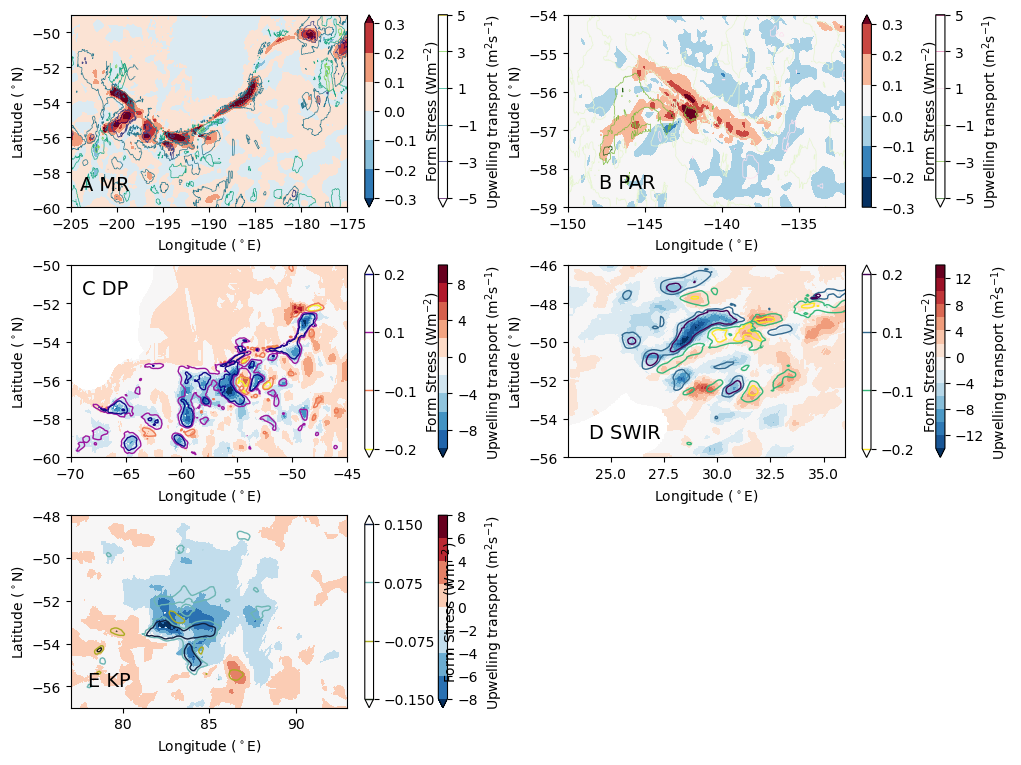

In [124]:
fig = plt.figure(num=1,figsize=(12,9))
gs = gridspec.GridSpec(3,2) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0])
gs.update(hspace = 0.3, wspace=0.15)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp
p0 = (transport_new).plot.contour(ax= ax0,x = 'x_ocean', levels = [-5,-3,-1,1,3,5], cmap = 'viridis', add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
#p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0, add_colorbar = False, levels = [0,1,2,3,4,5], cmap = newcmap, linewidth =1)#, linestyles = '--')
cb = plt.colorbar(p1,ax=ax0, orientation='vertical')
cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
ax0.text(-204,-59,'A MR', fontsize = 14);
                                                                                                       
transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contour(ax= ax1,x = 'x_ocean', levels = [-5,-3,-1,1,3,5], cmap = 'PiYG_r', add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1,cmap = 'RdBu_r', levels = [-0.3,-0.2,-0.1,0,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
#p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1, add_colorbar = False,levels = [0,0.5,1,1.5,2,2.5,3], cmap = newcmap, linewidth = 0.5)#, linestyles = '--')
cb = plt.colorbar(p1,ax=ax1, orientation='vertical')
cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
ax1.text(-148,-58.5,'B PAR', fontsize = 14);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-10,11,2), cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
#p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contourf(ax = ax2, add_colorbar = False,levels = [0,1,2,3,4,5], cmap = newcmap, linewidth = 0.5)#, linestyles = '--')
cb = plt.colorbar(p1,ax=ax2, orientation='vertical')
cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
ax2.text(-69,-51.5,'C DP', fontsize = 14);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-14,15,2), cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'viridis_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
#p2 = (EKE_upwelling/1e4).sel(yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contourf(ax = ax3, add_colorbar = False,levels = [0,1,2,3,4,5], cmap = newcmap, linewidth = 0.5)#, linestyles = '--')
cb = plt.colorbar(p1,ax=ax3, orientation='vertical')
cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
ax3.text(24,-55,'D SWIR', fontsize = 14);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,9,2), cmap = 'RdBu_r', add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)')
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_upwelling_KP = EKE_upwelling.roll(xt_ocean =800)
EKE_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = cm.cm.delta_r, levels = [-0.15,-0.075,0.075,0.15], add_colorbar = False, linewidths = 1)
#p2 = (EKE_upwelling_KP/1e4).sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contourf(ax = ax4, add_colorbar = False,levels = [0,1,2,3,4,5], cmap = newcmap, linewidths = 0.5)#, linestyles = '--')
cb = plt.colorbar(p1,ax=ax4, orientation='vertical')
cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
ax4.text(78,-56,'E KP', fontsize = 14);

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('Longitude ($^\circ$E)')
ax1.set_ylabel('Latitude ($^\circ$N)')
ax1.set_xlabel('Longitude ($^\circ$E)')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-205,-175)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)


In [18]:
import matplotlib as mpl


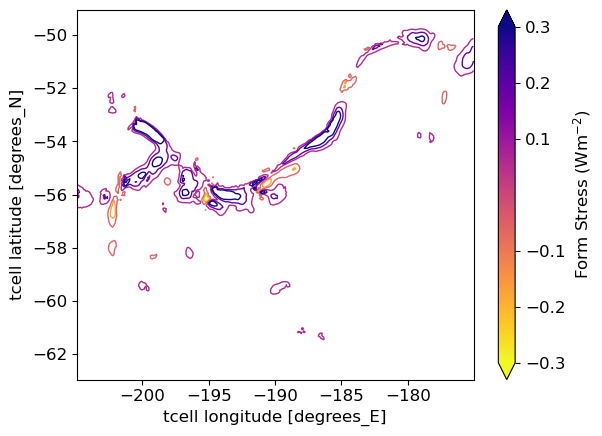

In [62]:
fig = plt.figure()
ax0 = fig.add_subplot()
p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'plasma_r', levels = [-0.3,-0.2,-0.1,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)

# cmap = mpl.cm.plasma_r
# bounds = [1,2,3,5,6,7]
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# cb = fig.colorbar(
#     mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#     ax=ax0,
#     boundaries=[0] + bounds + [13],  # Adding values for extensions.
#     extend='both',
#     ticks=bounds,
#     spacing='proportional',
#     orientation='vertical',
#     label='Discrete intervals, some other units',
# )
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='Form Stress (Wm$^{-2}$)', spacing='proportional', extend = 'both', ticks = [-0.3,-0.2,-0.1,0.1,0.2,0.3])
#cb = fig.colorbar(p1,ax=ax0, orientation='vertical', pad = 0.02, spacing='proportional',extend='both')
#cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cb.ax.set_yticks([-0.3,-0.2,-0.1,0.1,0.2,0.3])

(-57.0, -48.0)

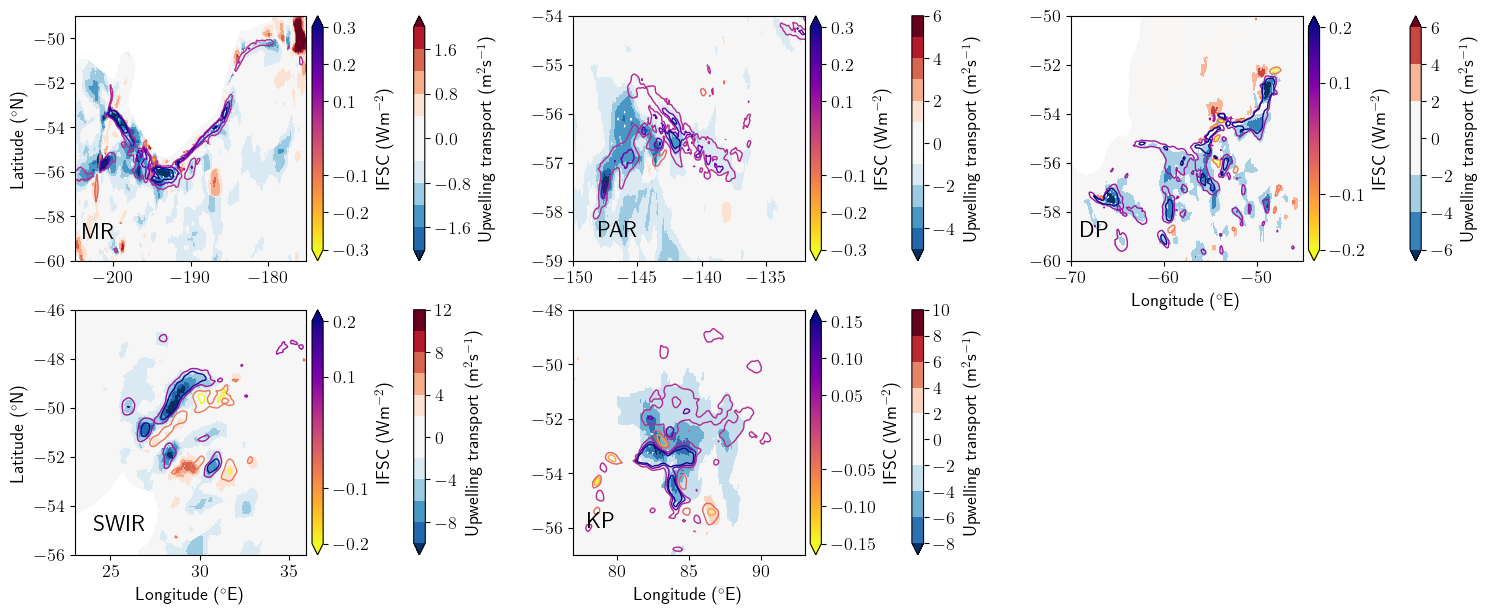

In [19]:
newcmap = cm.tools.crop_by_percent(cm.cm.tempo, 30, which='both', N= None)
fig = plt.figure(num=1,figsize=(18,7))
gs = gridspec.GridSpec(2,3) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1])
gs.update(hspace = 0.2, wspace=0.25)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp
p0 = (transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = np.arange(-2.0,2.1,0.4), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
FS_upwelling = Form_stress.sel(isopycnal_bins = slice(1032.2962295,1032.51)).sum('isopycnal_bins')
p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'plasma_r', levels = [-0.3,-0.2,-0.1,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
#cb = plt.colorbar(p1,ax=ax0, orientation='vertical', pad = 0.02, spacing = 'proportional', extend='both')
#cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.3,-0.2,-0.1,0.1,0.2,0.3])

ax0.text(-204,-59,'MR', fontsize = 16);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = np.arange(-5,7,1), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
FS_upwelling = Form_stress.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')
p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'plasma_r', levels = [-0.3,-0.2,-0.1,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax1, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax1, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.3,-0.2,-0.1,0.1,0.2,0.3])

ax1.text(-148,-58.5,'PAR', fontsize = 16);
#############################################################################################


transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-6,7,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
FS_upwelling = Form_stress.sel(isopycnal_bins = slice(1032.13010113,1032.48)).sum('isopycnal_bins')
p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax2, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax2, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.2,-0.1,0.1,0.2])

ax2.text(-69,-59,'DP', fontsize = 16);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-10,13,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
FS_upwelling = Form_stress.sel(isopycnal_bins = slice(1032.13490907,1032.48)).sum('isopycnal_bins')
p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax3, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax3, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.2,-0.1,0.1,0.2])

ax3.text(24,-55,'SWIR', fontsize = 16);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,11,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', extend = 'both', pad = 0.15)
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
FS_upwelling_KP = Form_stress.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').roll(xt_ocean = 800)
FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma_r', levels = [-0.15,-0.1,-0.05,0.05,0.1,0.15], add_colorbar = False, linewidths = 1)
#p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma_r', levels = [-0.15,-0.1,-0.05,0.05,0.1,0.15], add_colorbar = False, linewidths = 1)

# cb = plt.colorbar(p1,ax=ax4, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.15, vmax=0.15)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax4, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.15,-0.1,-0.05,0.05,0.1,0.15])

ax4.text(78,-56,'KP', fontsize = 16);
#############################################################################################

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-205,-175)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)

#fig.savefig('FSinterp.png', dpi = 400)

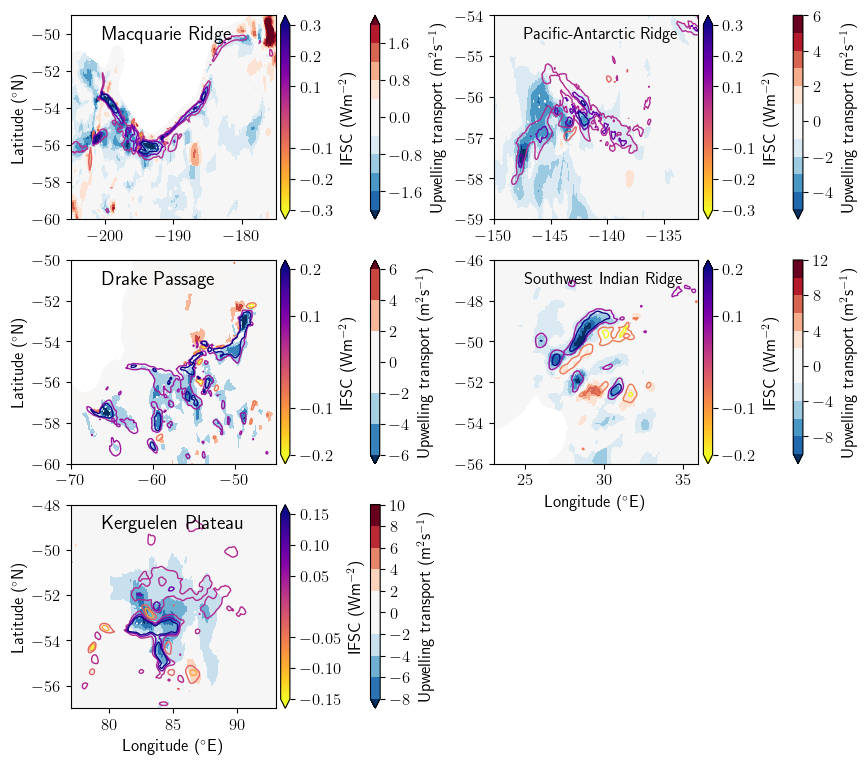

In [25]:
newcmap = cm.tools.crop_by_percent(cm.cm.tempo, 30, which='both', N= None)
fig = plt.figure(num=1,figsize=(10,9))
gs = gridspec.GridSpec(3,2) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0])
gs.update(hspace = 0.2, wspace=0.2)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp
p0 = (transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = np.arange(-2.0,2.1,0.4), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
FS_upwelling = Form_stress.sel(isopycnal_bins = slice(1032.2962295,1032.51)).sum('isopycnal_bins')
p1 = FS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'plasma_r', levels = [-0.3,-0.2,-0.1,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
#cb = plt.colorbar(p1,ax=ax0, orientation='vertical', pad = 0.02, spacing = 'proportional', extend='both')
#cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.3,-0.2,-0.1,0.1,0.2,0.3])

ax0.text(0.15,0.88,'Macquarie Ridge', fontsize = 14, transform=ax0.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = np.arange(-5,7,1), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
FS_upwelling = Form_stress.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')
p1 = FS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'plasma_r', levels = [-0.3,-0.2,-0.1,0.1,0.2,0.3], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax1, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax1, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.3,-0.2,-0.1,0.1,0.2,0.3])

ax1.text(0.15,0.88,'Pacific-Antarctic Ridge', fontsize = 12, transform=ax1.transAxes);
#############################################################################################


transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-6,7,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
FS_upwelling = Form_stress.sel(isopycnal_bins = slice(1032.13010113,1032.48)).sum('isopycnal_bins')
p1 = FS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax2, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax2, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.2,-0.1,0.1,0.2])

ax2.text(0.15,0.88,'Drake Passage', fontsize = 14, transform=ax2.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-10,13,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
FS_upwelling = Form_stress.sel(isopycnal_bins = slice(1032.13490907,1032.48)).sum('isopycnal_bins')
p1 = FS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'plasma_r', levels = [-0.2,-0.1,0.1,0.2], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax3, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax3, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.2,-0.1,0.1,0.2])

ax3.text(0.15,0.88,'Southwest Indian Ridge', fontsize = 12, transform=ax3.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,11,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', extend = 'both', pad = 0.15)
#FS_upwelling_KP = FS_upwelling.roll(xt_ocean = 800)
#FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
FS_upwelling_KP = Form_stress.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').roll(xt_ocean = 800)
FS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma_r', levels = [-0.15,-0.1,-0.05,0.05,0.1,0.15], add_colorbar = False, linewidths = 1)
#p1 = FS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma_r', levels = [-0.15,-0.1,-0.05,0.05,0.1,0.15], add_colorbar = False, linewidths = 1)

# cb = plt.colorbar(p1,ax=ax4, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.15, vmax=0.15)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax4, orientation='vertical', label='IFSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.15,-0.1,-0.05,0.05,0.1,0.15])

ax4.text(0.15,0.88,'Kerguelen Plateau', fontsize = 14, transform=ax4.transAxes);
#############################################################################################

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-205,-175)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)

fig.savefig('FSinterp.png', dpi = 400)

# Reynolds

(-57.0, -48.0)

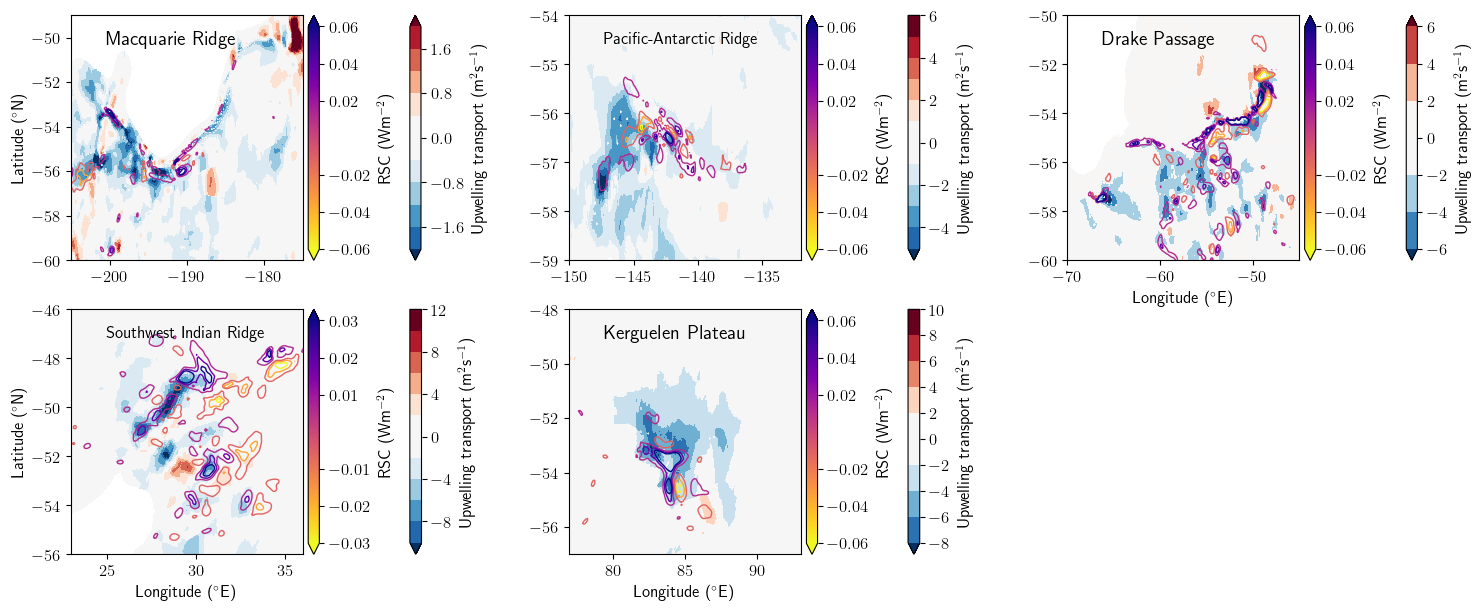

In [26]:
newcmap = cm.tools.crop_by_percent(cm.cm.tempo, 30, which='both', N= None)
fig = plt.figure(num=1,figsize=(18,7))
gs = gridspec.GridSpec(2,3) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1])
gs.update(hspace = 0.2, wspace=0.25)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp
p0 = (transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = np.arange(-2.0,2.1,0.4), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
RS_upwelling = Reynolds.sel(isopycnal_bins = slice(1032.2962295,1032.51)).sum('isopycnal_bins')
p1 = RS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'plasma_r', levels = [-0.06,-0.04,-0.02,0.02,0.04,0.06], add_colorbar = False, linewidths = 1)
#cb = plt.colorbar(p1,ax=ax0, orientation='vertical', pad = 0.02, spacing = 'proportional', extend='both')
#cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.06, vmax=0.06)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.06,-0.04,-0.02,0.02,0.04,0.06])

ax0.text(0.15,0.88,'Macquarie Ridge', fontsize = 14, transform=ax0.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = np.arange(-5,7,1), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
RS_upwelling = Reynolds.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')
p1 = RS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'plasma_r', levels = [-0.06,-0.04,-0.02,0.02,0.04,0.06], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax1, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.06, vmax=0.06)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax1, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.06,-0.04,-0.02,0.02,0.04,0.06])

ax1.text(0.15,0.88,'Pacific-Antarctic Ridge', fontsize = 12, transform=ax1.transAxes);
#############################################################################################


transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-6,7,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
RS_upwelling = Reynolds.sel(isopycnal_bins = slice(1032.13010113,1032.48)).sum('isopycnal_bins')
p1 = RS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.06,-0.04,-0.02,0.02,0.04,0.06], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax2, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.06, vmax=0.06)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax2, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.06,-0.04,-0.02,0.02,0.04,0.06])

ax2.text(0.15,0.88,'Drake Passage', fontsize = 14, transform=ax2.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-10,13,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
RS_upwelling = Reynolds.sel(isopycnal_bins = slice(1032.13490907,1032.48)).sum('isopycnal_bins')
p1 = RS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'plasma_r', levels = [-0.03,-0.02,-0.01,0.01,0.02,0.03], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax3, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.03, vmax=0.03)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax3, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.03,-0.02,-0.01,0.01,0.02,0.03])

ax3.text(0.15,0.88,'Southwest Indian Ridge', fontsize = 12, transform=ax3.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,11,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', extend = 'both', pad = 0.15)
RS_upwelling_KP = Reynolds.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').roll(xt_ocean = 800)
RS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = RS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma_r', levels = [-0.06,-0.04,-0.02,0.02,0.04,0.06], add_colorbar = False, linewidths = 1)

# cb = plt.colorbar(p1,ax=ax4, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.06, vmax=0.06)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax4, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.06,-0.04,-0.02,0.02,0.04,0.06])

ax4.text(0.15,0.88,'Kerguelen Plateau', fontsize = 14, transform=ax4.transAxes);
#############################################################################################

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-205,-175)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)

#fig.savefig('RSinterp.png', dpi = 400)


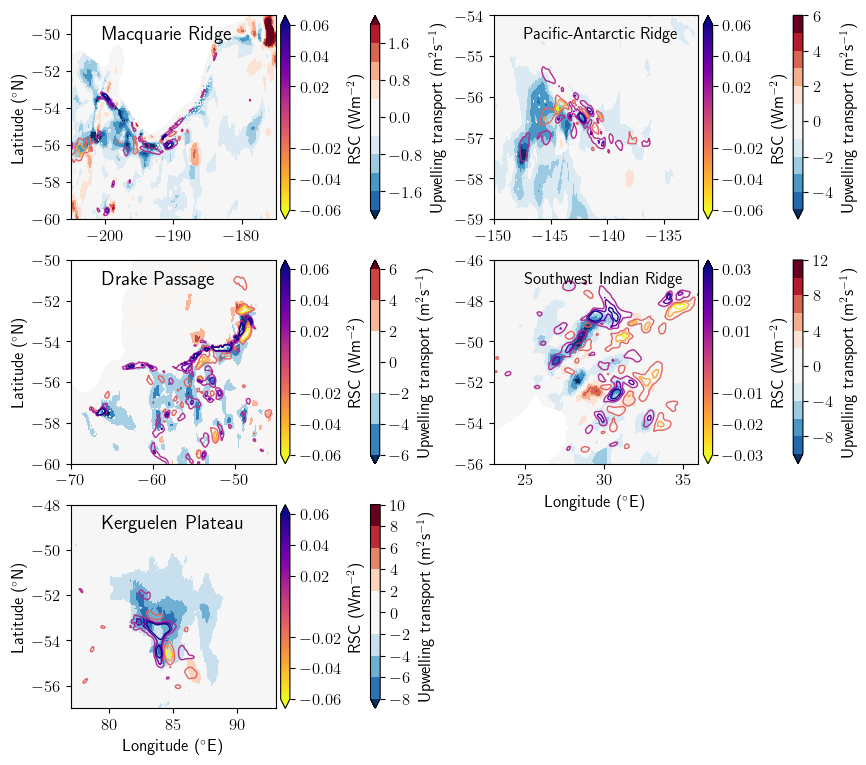

In [27]:
newcmap = cm.tools.crop_by_percent(cm.cm.tempo, 30, which='both', N= None)
fig = plt.figure(num=1,figsize=(10,9))
gs = gridspec.GridSpec(3,2) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[2,0])
gs.update(hspace = 0.2, wspace=0.2)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp
p0 = (transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = np.arange(-2.0,2.1,0.4), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax0, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
RS_upwelling = Reynolds.sel(isopycnal_bins = slice(1032.2962295,1032.51)).sum('isopycnal_bins')
p1 = RS_upwelling.sel(yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'plasma_r', levels = [-0.06,-0.04,-0.02,0.02,0.04,0.06], add_colorbar = False, linewidths = 1)
#cb = plt.colorbar(p1,ax=ax0, orientation='vertical', pad = 0.02, spacing = 'proportional', extend='both')
#cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.06, vmax=0.06)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax0, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.06,-0.04,-0.02,0.02,0.04,0.06])

ax0.text(0.15,0.88,'Macquarie Ridge', fontsize = 14, transform=ax0.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                  
p0 = (transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = np.arange(-5,7,1), cmap = tmap, add_colorbar = False, linewidths = 0.5)
cb = plt.colorbar(p0,ax=ax1, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
RS_upwelling = Reynolds.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')
p1 = RS_upwelling.sel(yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'plasma_r', levels = [-0.06,-0.04,-0.02,0.02,0.04,0.06], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax1, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.06, vmax=0.06)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax1, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.06,-0.04,-0.02,0.02,0.04,0.06])

ax1.text(0.15,0.88,'Pacific-Antarctic Ridge', fontsize = 12, transform=ax1.transAxes);
#############################################################################################


transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = np.arange(-6,7,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax2, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
RS_upwelling = Reynolds.sel(isopycnal_bins = slice(1032.13010113,1032.48)).sum('isopycnal_bins')
p1 = RS_upwelling.sel( yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'plasma_r', levels = [-0.06,-0.04,-0.02,0.02,0.04,0.06], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax2, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.06, vmax=0.06)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax2, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.06,-0.04,-0.02,0.02,0.04,0.06])

ax2.text(0.15,0.88,'Drake Passage', fontsize = 14, transform=ax2.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = np.arange(-10,13,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax3, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', pad = 0.15)
RS_upwelling = Reynolds.sel(isopycnal_bins = slice(1032.13490907,1032.48)).sum('isopycnal_bins')
p1 = RS_upwelling.sel( yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'plasma_r', levels = [-0.03,-0.02,-0.01,0.01,0.02,0.03], add_colorbar = False, linewidths = 1)
# cb = plt.colorbar(p1,ax=ax3, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.03, vmax=0.03)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax3, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.03,-0.02,-0.01,0.01,0.02,0.03])

ax3.text(0.15,0.88,'Southwest Indian Ridge', fontsize = 12, transform=ax3.transAxes);
#############################################################################################

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp                                                                                                       
p0 = (transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = np.arange(-8,11,2), cmap = tmap, add_colorbar = False, linewidths = 1)
cb = plt.colorbar(p0,ax=ax4, label = 'Upwelling transport (m$^{2}$s$^{-1}$)', extend = 'both', pad = 0.15)
RS_upwelling_KP = Reynolds.sel(isopycnal_bins=slice(1032.19249245,1032.48)).sum('isopycnal_bins').roll(xt_ocean = 800)
RS_upwelling_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = RS_upwelling_KP.sel( yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'plasma_r', levels = [-0.06,-0.04,-0.02,0.02,0.04,0.06], add_colorbar = False, linewidths = 1)

# cb = plt.colorbar(p1,ax=ax4, orientation='vertical', pad = 0.02)
# cb.ax.set_ylabel('Form Stress (Wm$^{-2}$)');
cmap = mpl.cm.plasma_r
norm =  mpl.colors.Normalize(vmin=-0.06, vmax=0.06)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax4, orientation='vertical', label='RSC (Wm$^{-2}$)', spacing='proportional', extend = 'both', pad = 0.02, ticks = [-0.06,-0.04,-0.02,0.02,0.04,0.06])

ax4.text(0.15,0.88,'Kerguelen Plateau', fontsize = 14, transform=ax4.transAxes);
#############################################################################################

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax0.set_xlim(-205,-175)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax2.set_xlim(-70,-45)
ax2.set_ylim(-60,-50)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)

fig.savefig('RSinterp.png', dpi = 400)


# OLD PLOT

Text(105, -50, 'Grey lines at EKE=4x$ 10^3$ (MR and PAR) and 4x$ 10^4$ (others)')

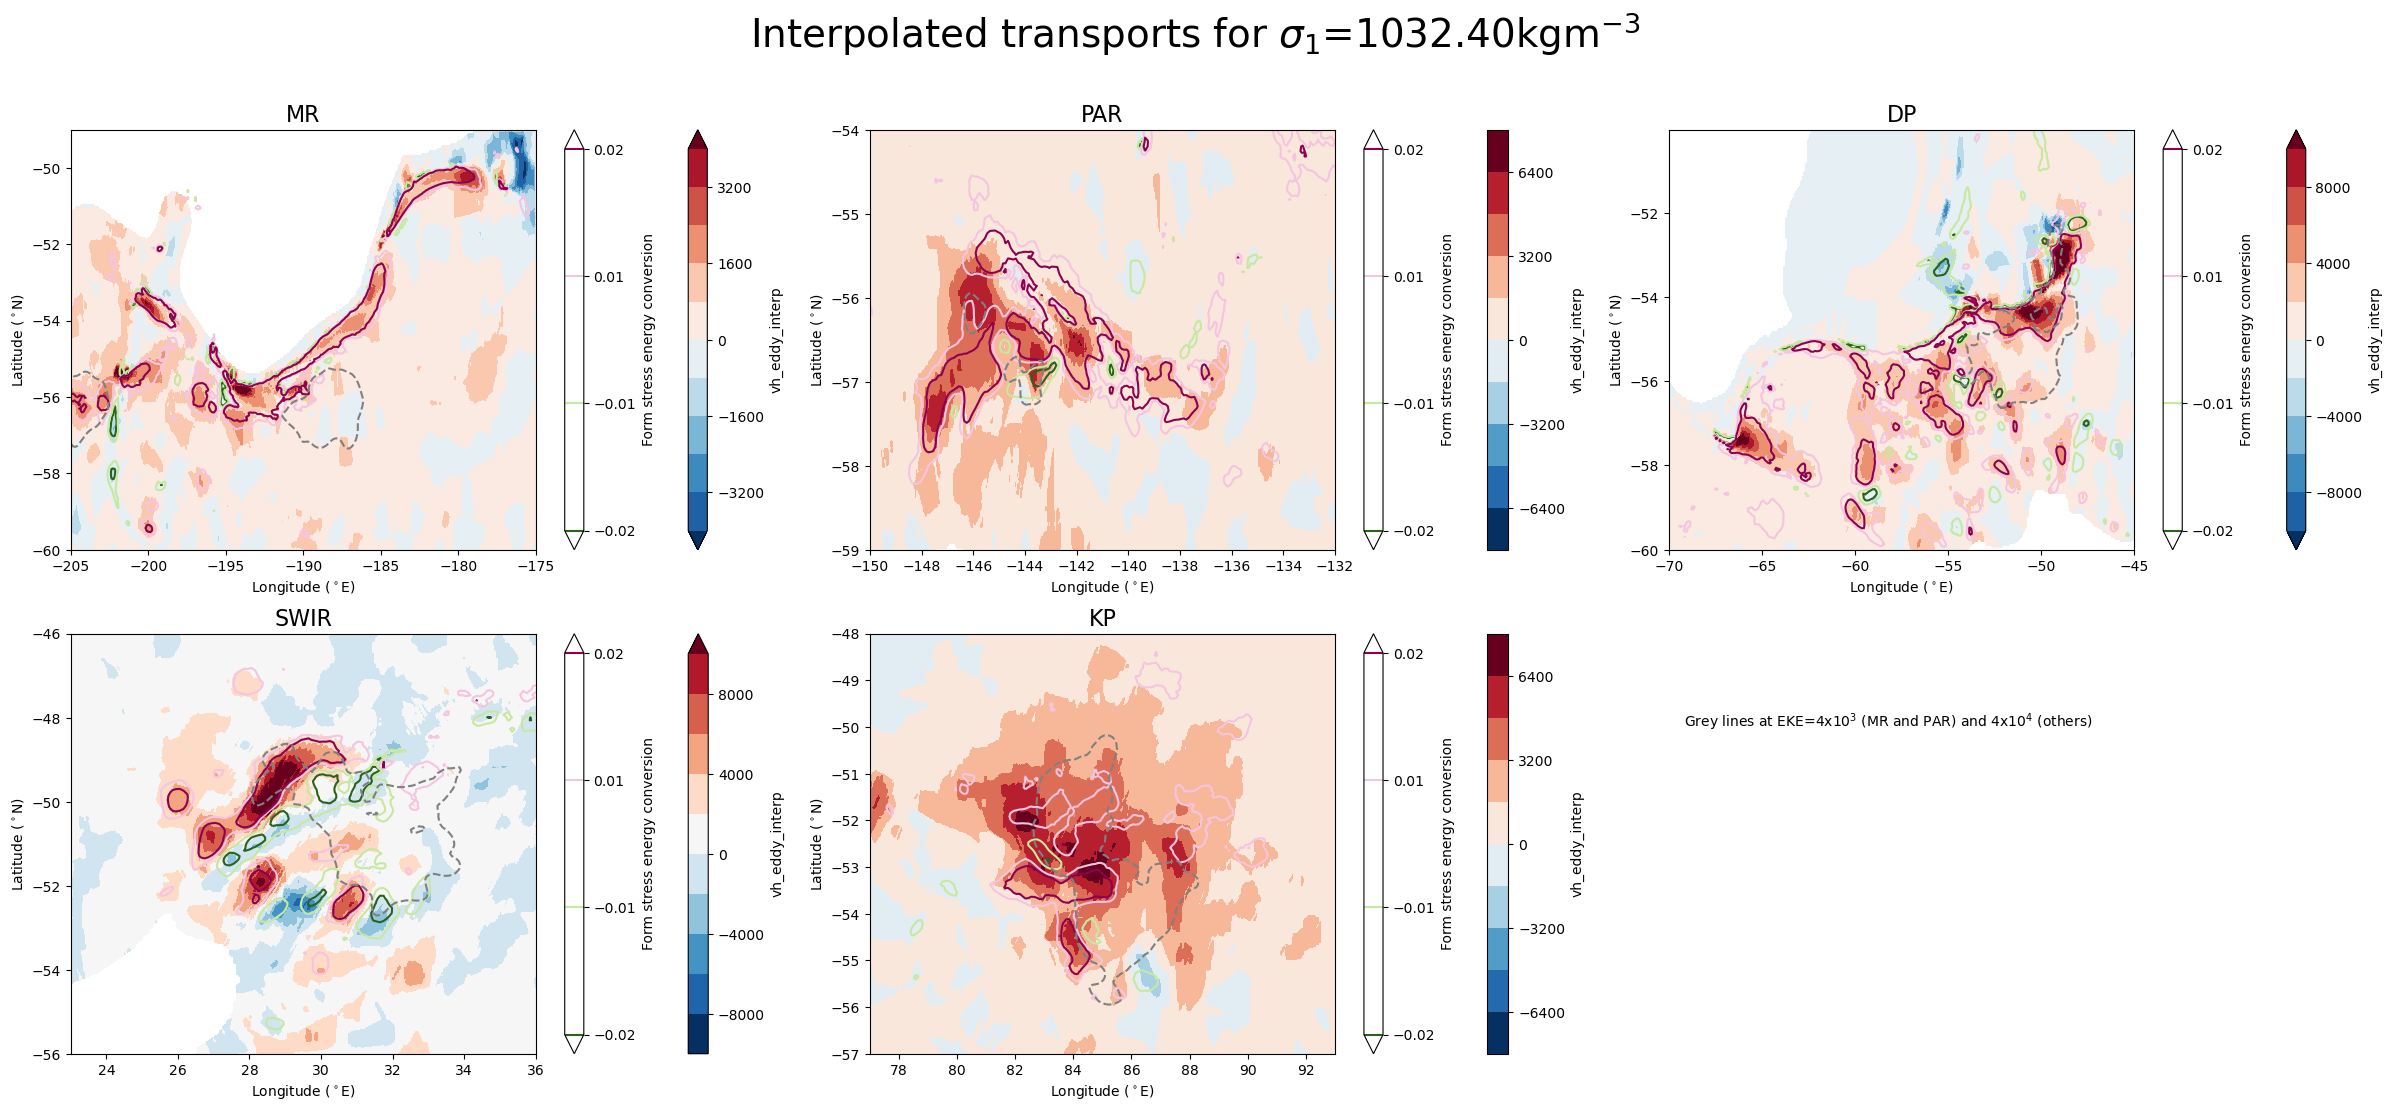

In [12]:
fig = plt.figure(num=1,figsize=(30,12))
gs = gridspec.GridSpec(2,3) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1])
gs.update(hspace = 0.2, wspace=0.1)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_1032.4.nc').vh_eddy_interp
(-transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = 11, vmax = 4000, vmin = -4000, cmap = 'RdBu_r')
p1 = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0, levels = [3e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax0, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax0.set_title('MR', fontsize = 16);
                                                                                                       
transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                  
(-transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = 11, vmax = 8000, vmin = -8000, cmap = 'RdBu_r')
p1 = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1, levels = [3e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax1, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax1.set_title('PAR', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = 11, vmax = 10000, vmin = -10000, cmap = 'RdBu_r')
p1 = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax2, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax2.set_title('DP', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = 11, vmax = 10000, vmin = -10000, cmap = 'RdBu_r')
p1 = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax3, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax3.set_title('SWIR', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = 11, vmax = 8000, vmin = -8000, cmap = 'RdBu_r')
Form_stress_KP = Form_stress.roll(xt_ocean = 800)
Form_stress_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_KP = EKE.roll(xt_ocean =800)
EKE_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = Form_stress_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
p2 = EKE_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax4, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax4.set_title('KP', fontsize = 16);

fig.suptitle('Interpolated transports for $\sigma_1$=1032.40kgm$^{-3}$', fontsize = 28)

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('Longitude ($^\circ$E)')
ax1.set_ylabel('Latitude ($^\circ$N)')
ax1.set_xlabel('Longitude ($^\circ$E)')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)
ax4.text(105,-50,'Grey lines at EKE=4x$ 10^3$ (MR and PAR) and 4x$ 10^4$ (others)')

Text(-215, -55, 'EKE')

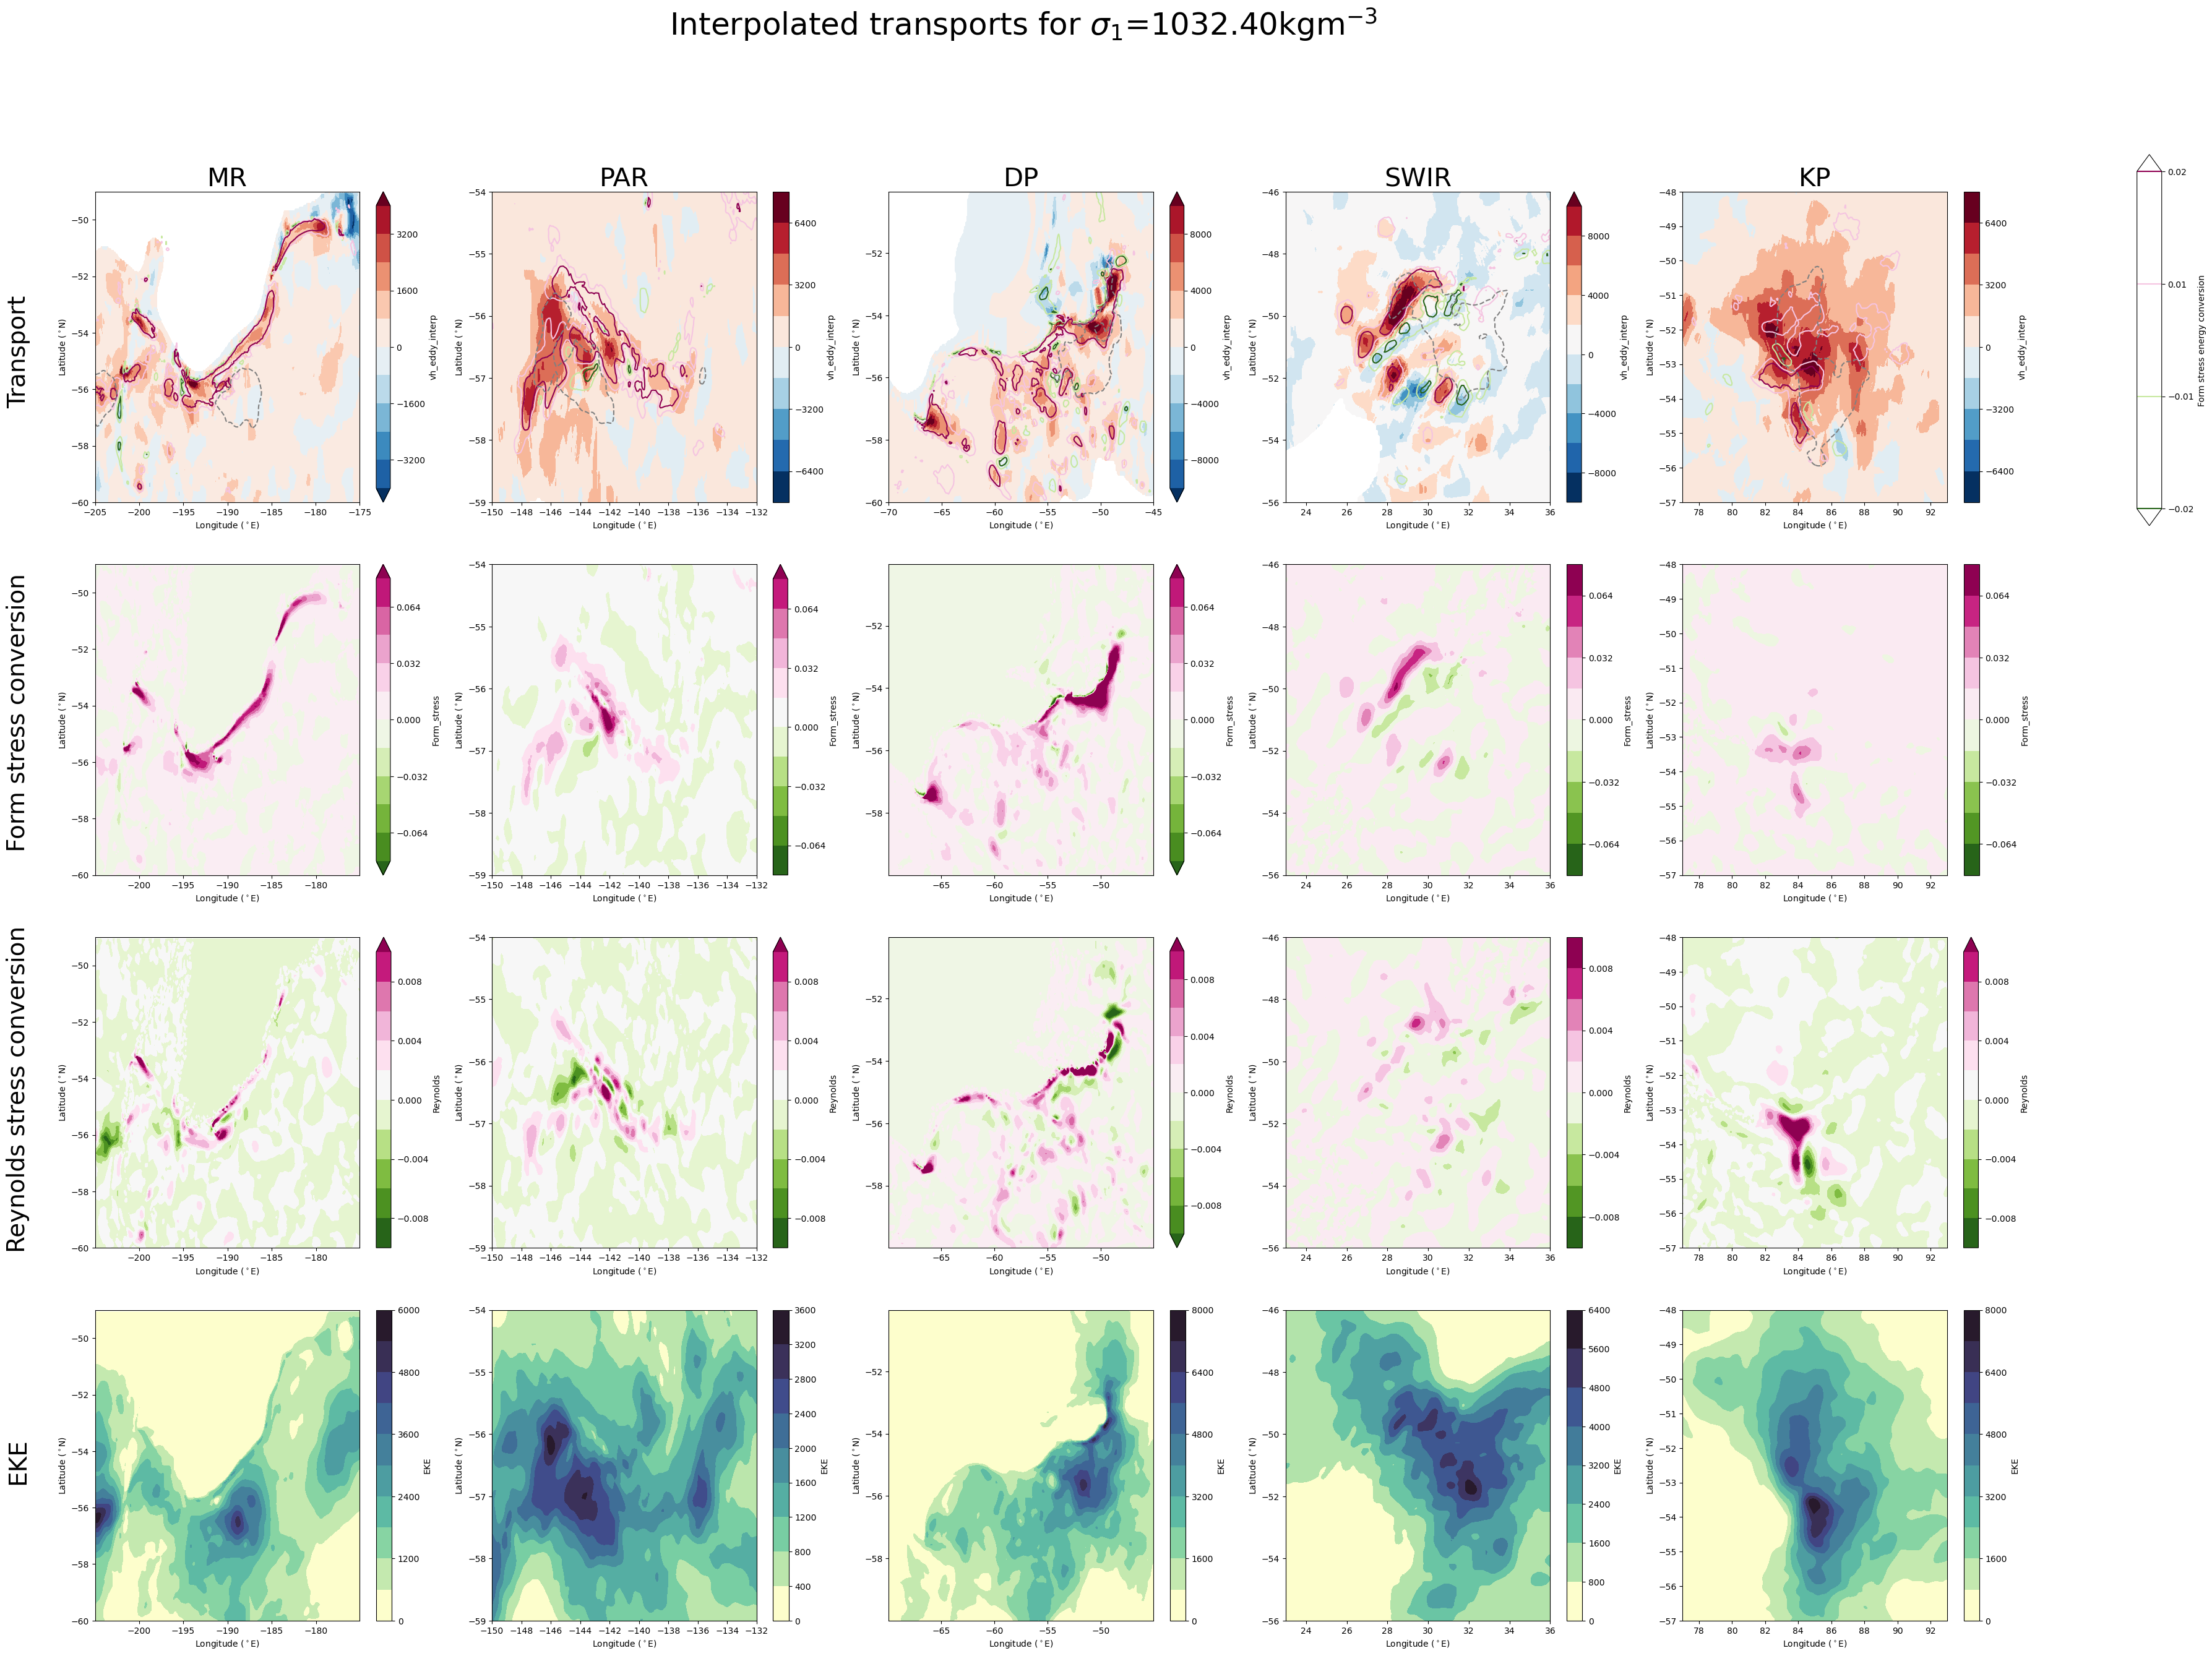

In [33]:
fig = plt.figure(num=1,figsize=(40,30))
gs = gridspec.GridSpec(4,5) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[0,3]), plt.subplot(gs[0,4])
ax0F, ax1F, ax2F, ax3F, ax4F = plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[1,2]), plt.subplot(gs[1,3]), plt.subplot(gs[1,4])
ax0R, ax1R, ax2R, ax3R, ax4R = plt.subplot(gs[2,0]), plt.subplot(gs[2,1]), plt.subplot(gs[2,2]), plt.subplot(gs[2,3]), plt.subplot(gs[2,4])
ax0E, ax1E, ax2E, ax3E, ax4E = plt.subplot(gs[3,0]), plt.subplot(gs[3,1]), plt.subplot(gs[3,2]), plt.subplot(gs[3,3]), plt.subplot(gs[3,4])

gs.update(hspace = 0.2, wspace=0.2)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_1032.4.nc').vh_eddy_interp
(-transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = 11, vmax = 4000, vmin = -4000, cmap = 'RdBu_r')
p1 = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0F,cmap = 'PiYG_r', levels = 11, vmin = -0.08,vmax= 0.08)
Reynolds.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0R,cmap = 'PiYG_r', levels = 11, vmin = -0.01,vmax= 0.01)
EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contourf(ax = ax0E,cmap = 'cmo.deep', levels = 11)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0, levels = [3e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
# cb = plt.colorbar(p1,ax=ax0, orientation='vertical')
# cb.ax.set_ylabel('Form stress energy conversion');
ax0.set_title('MR', fontsize = 30);
                                                                                                       
transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                  
(-transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = 11, vmax = 8000, vmin = -8000, cmap = 'RdBu_r')
p1 = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1F,cmap = 'PiYG_r', levels = 11 , vmin = -0.08,vmax= 0.08)
Reynolds.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1R,cmap = 'PiYG_r', levels = 11, vmin = -0.01,vmax= 0.01)
EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contourf(ax = ax1E,cmap = 'cmo.deep', levels = 11)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1, levels = [2.5e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
# cb = plt.colorbar(p1,ax=ax1, orientation='vertical')
# cb.ax.set_ylabel('Form stress energy conversion');
ax1.set_title('PAR', fontsize = 30);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = 11, vmax = 10000, vmin = -10000, cmap = 'RdBu_r')
p1 = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contourf(ax = ax2F,cmap = 'PiYG_r', levels = 11, vmin = -0.08,vmax= 0.08)
Reynolds.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contourf(ax = ax2R,cmap = 'PiYG_r', levels = 11, vmin = -0.01,vmax= 0.01)
EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contourf(ax = ax2E,cmap = 'cmo.deep', levels = 11)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
# cb = plt.colorbar(p1,ax=ax2, orientation='vertical')
# cb.ax.set_ylabel('Form stress energy conversion');
ax2.set_title('DP', fontsize = 30);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = 11, vmax = 10000, vmin = -10000, cmap = 'RdBu_r')
p1 = Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
Form_stress.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contourf(ax = ax3F,cmap = 'PiYG_r', levels = 11, vmin = -0.08,vmax= 0.08)
Reynolds.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contourf(ax = ax3R,cmap = 'PiYG_r', levels = 11, vmin = -0.01,vmax= 0.01)
EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contourf(ax = ax3E,cmap = 'cmo.deep', levels = 11)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
# cb = plt.colorbar(p1,ax=ax3, orientation='vertical')
# cb.ax.set_ylabel('Form stress energy conversion');
ax3.set_title('SWIR', fontsize = 30);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = 11, vmax = 8000, vmin = -8000, cmap = 'RdBu_r')
Form_stress_KP = Form_stress.roll(xt_ocean = 800)
Form_stress_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_KP = EKE.roll(xt_ocean =800)
EKE_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
Reynolds_KP = Reynolds.roll(xt_ocean =800)
Reynolds_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = Form_stress_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'PiYG_r', levels = [-0.02,-0.01,0.01,0.02], linewidth = 0.5)
Form_stress_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contourf(ax = ax4F,cmap = 'PiYG_r', levels = 11, vmin = -0.08,vmax= 0.08)
Reynolds_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contourf(ax = ax4R,cmap = 'PiYG_r', levels = 11, vmin = -0.01,vmax= 0.01)
EKE_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contourf(ax = ax4E,cmap = 'cmo.deep', levels = 11)
p2 = EKE_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
ax_cb = plt.axes([0.95, 0.7, 0.01, 0.2])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Form stress energy conversion');
ax4.set_title('KP', fontsize = 30);

fig.suptitle('Interpolated transports for $\sigma_1$=1032.40kgm$^{-3}$', fontsize = 36)

for ax in [ax0,ax1,ax2,ax3,ax4,ax0F,ax1F,ax2F,ax3F,ax4F,ax0R,ax1R,ax2R,ax3R,ax4R,ax0E,ax1E,ax2E,ax3E,ax4E]:
    ax.set_ylabel('Latitude ($^\circ$N)')
    ax.set_xlabel('Longitude ($^\circ$E)')

for ax in [ax0F,ax1F,ax2F,ax3F,ax4F,ax0R,ax1R,ax2R,ax3R,ax4R,ax0E,ax1E,ax2E,ax3E,ax4E]:
    ax.set_title('')
for ax in [ax0,ax0F,ax0R,ax0E]:
    ax.set_ylim(-60,-49)
for ax in [ax1,ax1F,ax1R,ax1E]:
    ax.set_xlim(-150,-132)
    ax.set_ylim(-59,-54)
for ax in [ax3,ax3F,ax3R,ax3E]:
    ax.set_xlim(23,36)
    ax.set_ylim(-56,-46)
for ax in [ax4,ax4F,ax4R,ax4E]:
    ax.set_xlim(77,93)
    ax.set_ylim(-57,-48)
    
ax0.text(-215, -56.5,'Transport', rotation = 90, fontsize = 28)
ax0F.text(-215, -59,'Form stress conversion', rotation = 90, fontsize = 28)
ax0R.text(-215, -60,'Reynolds stress conversion', rotation = 90, fontsize = 28)
ax0E.text(-215, -55,'EKE', rotation = 90, fontsize = 28)


Text(105, -50, 'Grey lines at EKE=4x$ 10^3$ (MR and PAR) and 4x$ 10^4$ (others)')

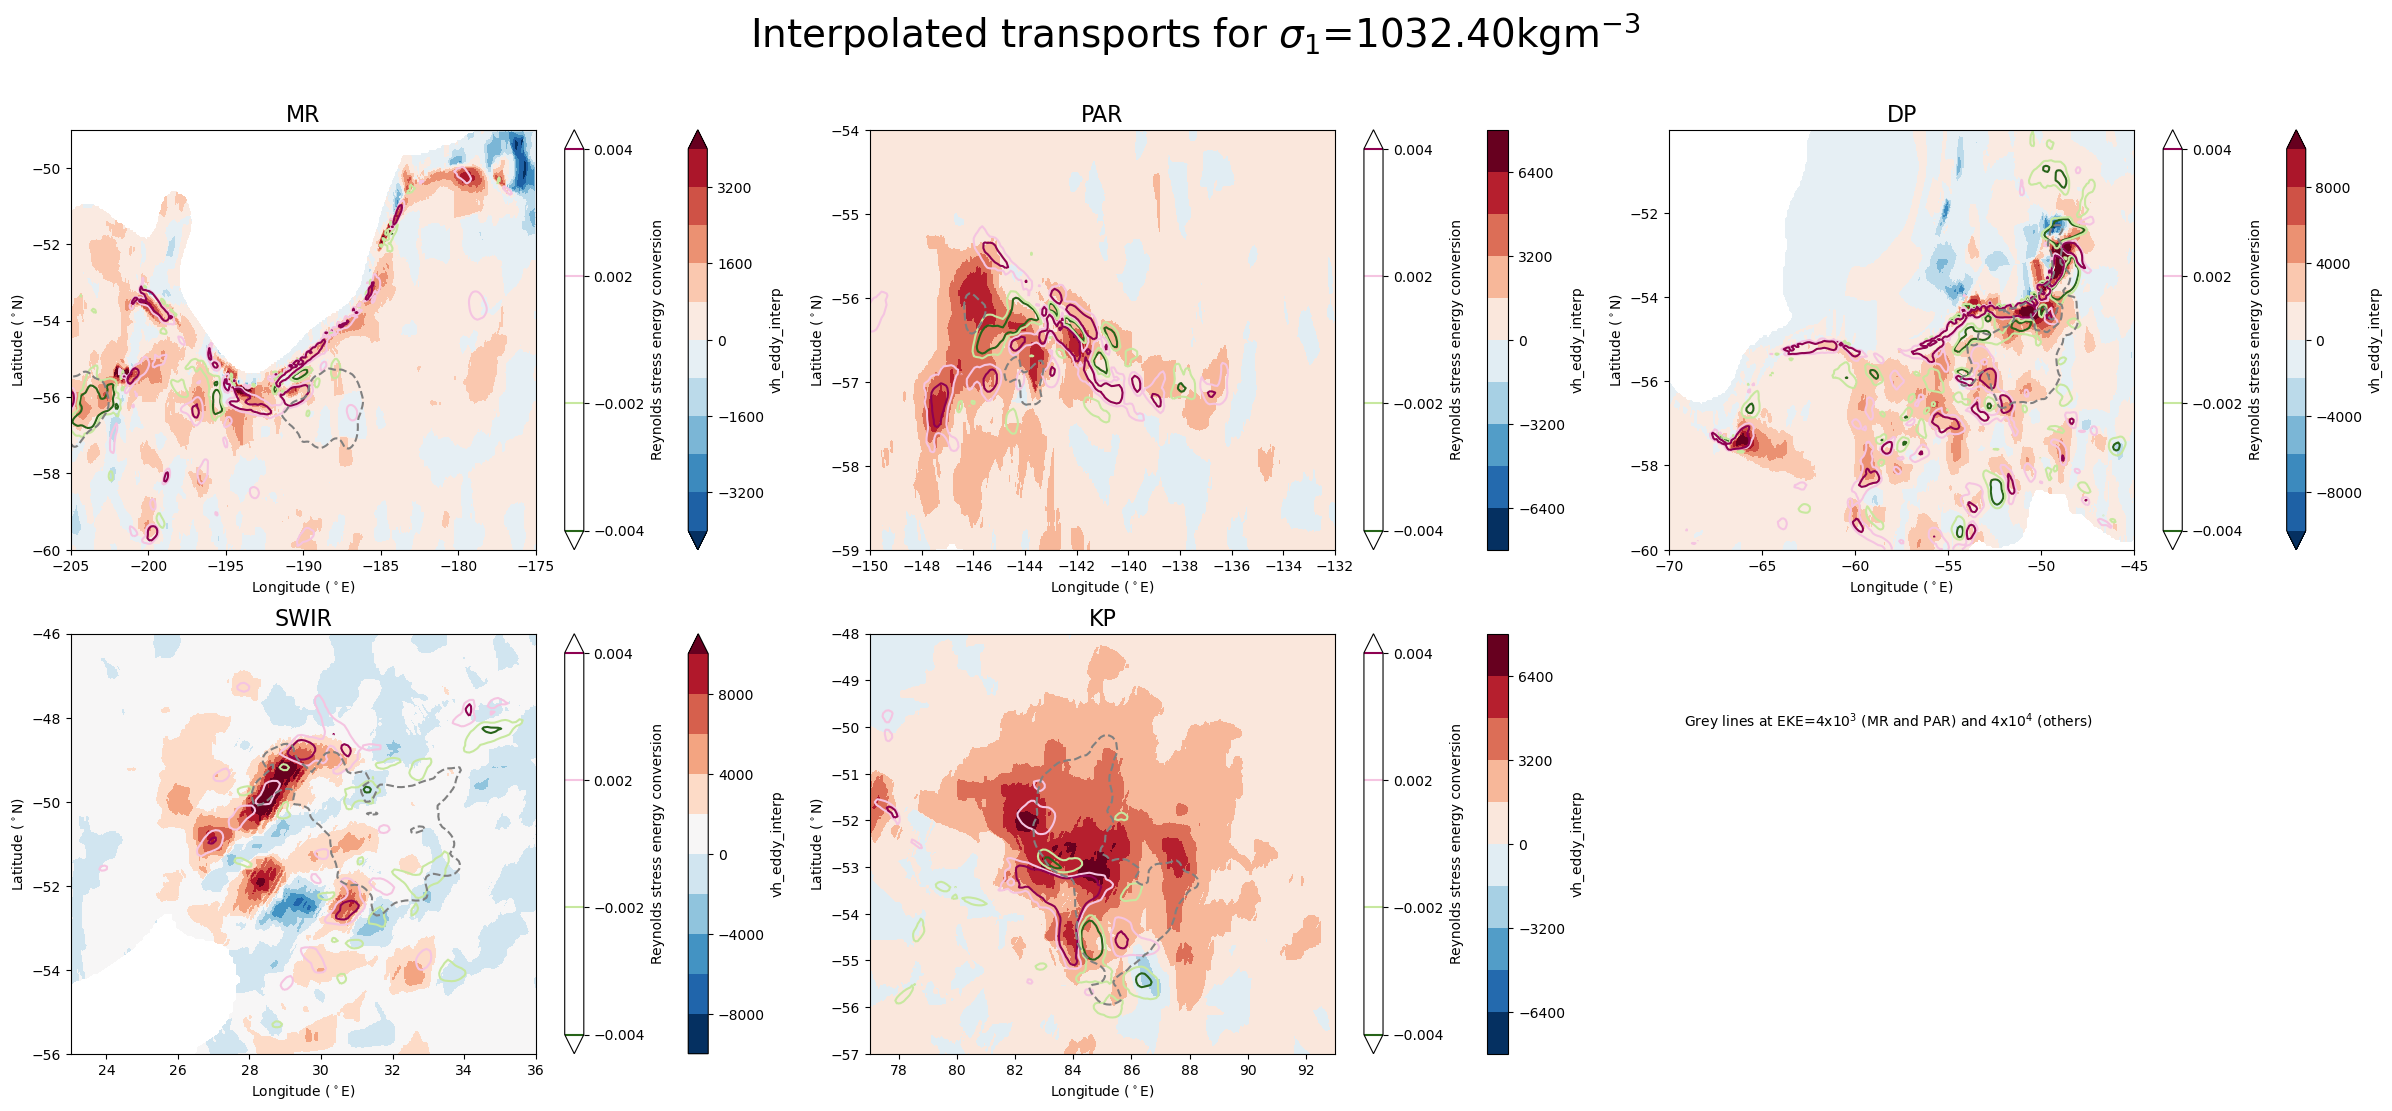

In [14]:
fig = plt.figure(num=1,figsize=(30,12))
gs = gridspec.GridSpec(2,3) 
ax0, ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1])
gs.update(hspace = 0.2, wspace=0.1)

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MR_vh_eddy_interp_1032.4.nc').vh_eddy_interp
(-transport_new).plot.contourf(ax= ax0,x = 'x_ocean', levels = 11, vmax = 4000, vmin = -4000, cmap = 'RdBu_r')
p1 = Reynolds.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0,cmap = 'PiYG_r', levels = [-0.004,-0.002,0.002,0.004], linewidth = 0.5)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-63,-49),xt_ocean = slice(-205,-175)).plot.contour(ax = ax0, levels = [3e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax0, orientation='vertical')
cb.ax.set_ylabel('Reynolds stress energy conversion');
ax0.set_title('MR', fontsize = 16);
                                                                                                       
transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/PAR_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                  
(-transport_new).plot.contourf(ax= ax1,x = 'x_ocean', levels = 11, vmax = 8000, vmin = -8000, cmap = 'RdBu_r')
p1 = Reynolds.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1,cmap = 'PiYG_r', levels = [-0.004,-0.002,0.002,0.004], linewidth = 0.5)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-49),xt_ocean = slice(-155,-130)).plot.contour(ax = ax1, levels = [3e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax1, orientation='vertical')
cb.ax.set_ylabel('Reynolds stress energy conversion');
ax1.set_title('PAR', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax2,x = 'x_ocean', levels = 11, vmax = 10000, vmin = -10000, cmap = 'RdBu_r')
p1 = Reynolds.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2,cmap = 'PiYG_r', levels = [-0.004,-0.002,0.002,0.004], linewidth = 0.5)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-60,-50),xt_ocean = slice(-70,-45)).plot.contour(ax = ax2, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax2, orientation='vertical')
cb.ax.set_ylabel('Reynolds stress energy conversion');
ax2.set_title('DP', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SWIR_vh_eddy_interp.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax3,x = 'x_ocean', levels = 11, vmax = 10000, vmin = -10000, cmap = 'RdBu_r')
p1 = Reynolds.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3,cmap = 'PiYG_r', levels = [-0.004,-0.002,0.002,0.004], linewidth = 0.5)
p2 = EKE.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-58,-40),xt_ocean = slice(20,40)).plot.contour(ax = ax3, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax3, orientation='vertical')
cb.ax.set_ylabel('Reynolds stress energy conversion');
ax3.set_title('SWIR', fontsize = 16);

transport_new = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/KP_vh_eddy_interp_1032.4.nc').vh_eddy_interp                                                                                                       
(-transport_new).plot.contourf(ax= ax4,x = 'x_ocean', levels = 11, vmax = 8000, vmin = -8000, cmap = 'RdBu_r')
Reynolds_KP = Reynolds.roll(xt_ocean = 800)
Reynolds_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
EKE_KP = EKE.roll(xt_ocean =800)
EKE_KP['xt_ocean'] = np.arange(0.05,360.01,0.1)
p1 = Reynolds_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4,cmap = 'PiYG_r', levels = [-0.004,-0.002,0.002,0.004], linewidth = 0.5)
p2 = EKE_KP.sel(isopycnal_bins = 1032.4, yt_ocean = slice(-65,-43),xt_ocean = slice(60,100)).plot.contour(ax = ax4, levels = [4e3], colors = 'grey', linewidth = 0.5, linestyles = '--')
cb = plt.colorbar(p1,ax=ax4, orientation='vertical')
cb.ax.set_ylabel('Reynolds stress energy conversion');
ax4.set_title('KP', fontsize = 16);

fig.suptitle('Interpolated transports for $\sigma_1$=1032.40kgm$^{-3}$', fontsize = 28)

ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('Longitude ($^\circ$E)')
ax1.set_ylabel('Latitude ($^\circ$N)')
ax1.set_xlabel('Longitude ($^\circ$E)')
ax2.set_ylabel('Latitude ($^\circ$N)')
ax2.set_xlabel('Longitude ($^\circ$E)')
ax3.set_ylabel('Latitude ($^\circ$N)')
ax3.set_xlabel('Longitude ($^\circ$E)')
ax4.set_ylabel('Latitude ($^\circ$N)')
ax4.set_xlabel('Longitude ($^\circ$E)')

ax0.set_ylim(-60,-49)
ax1.set_xlim(-150,-132)
ax1.set_ylim(-59,-54)
ax3.set_xlim(23,36)
ax3.set_ylim(-56,-46)
ax4.set_xlim(77,93)
ax4.set_ylim(-57,-48)
ax4.text(105,-50,'Grey lines at EKE=4x$ 10^3$ (MR and PAR) and 4x$ 10^4$ (others)')